In [979]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

# Обработка данных, графики (EDA)

In [980]:
# Просматриваю какие столбцы в тест данных
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   

   ...  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0  ...          Employed       Associate         4.0   35067.0   
1  ...          Employed     High School        33.0   27001.0   
2  ...          Employed        Bachelor        28.0  278382.0   
3  ...          Employed     High School         0.0    9224.0   
4  ...          Employed        Bachelor        31.0    4502.0   

   BaseInterestRate InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.257790     0.251465          508.970230                0.288013   
1          0.086110     0.093173          514.675859                0.050585   
2          0.108436     0.115443         1268.276385                0.072571   
3          0.100686     0.112822          498.505187                0.225415   
4          0.110437     0.089037          756.035156                0.052721   

   LoanApproved  RiskScore  
0           0.0  66.176500  
1           1.0  28.495737  
2           1.0  34.488104  
3           1.0  36.910753  
4           1.0  31.347091  

[5 rows x 36 columns]

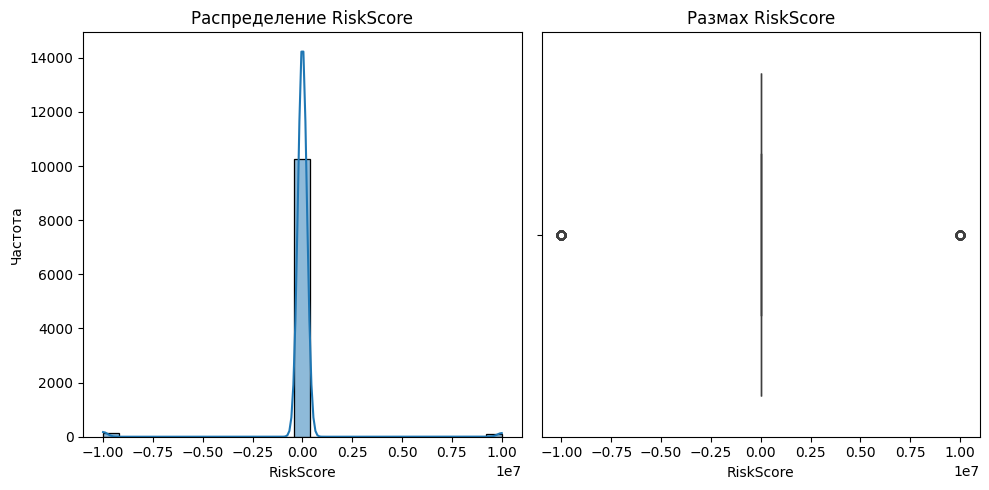

In [981]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['RiskScore'], kde=True, bins=25)
plt.title('Распределение RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['RiskScore'])
plt.title('Размах RiskScore')

plt.tight_layout()
plt.show()

In [982]:
train_df[train_df['RiskScore'] > 100]['RiskScore'].sort_values()

237      10000000.0
398      10000000.0
657      10000000.0
1168     10000000.0
1253     10000000.0
            ...    
9791     10000000.0
9929     10000000.0
10586    10000000.0
10601    10000000.0
10693    10000000.0
Name: RiskScore, Length: 94, dtype: float64

In [983]:
train_df[train_df['RiskScore'] < 0]['RiskScore'].sort_values()

33     -9999999.0
56     -9999999.0
83     -9999999.0
183    -9999999.0
198    -9999999.0
          ...    
9148   -9999999.0
9263   -9999999.0
9710   -9999999.0
9959   -9999999.0
9987   -9999999.0
Name: RiskScore, Length: 121, dtype: float64

Основные значения RiskScore находятся в диапозоне от 0 до 100, найденные выбросы будем считать "мусором". Так же проверим, есть ли null значения.

In [984]:
null_count = train_df['RiskScore'].isnull().sum()
print(f"Количество пропусков в 'RiskScore': {null_count}")
all_rows = train_df['RiskScore'].notnull().sum
print(f"Доля пропусков: {null_count / len(train_df):.2%}")

Количество пропусков в 'RiskScore': 530
Доля пропусков: 4.81%


Можем пренебречь 4.81% и удалить такие строки + удалим "мусор".

In [985]:
initial_count = len(train_df)
train_df = train_df[(train_df['RiskScore'] >= 0) & (train_df['RiskScore'] <= 100)]

train_df = train_df.dropna(subset=['RiskScore'])

print("\nАнализ пропусков по всем признакам:")
null_analysis = pd.DataFrame({
    'Количество null': train_df.isnull().sum(),
    'Процент null': (train_df.isnull().mean() * 100).round(2)
}).sort_values('Количество null', ascending=False)


null_analysis.style.format({'Процент null': '{:.2f}%'})


Анализ пропусков по всем признакам:


Теперь RiskScore не имеет пустых значений, перепроверим графики, что убедиться, что размах нормализовался.

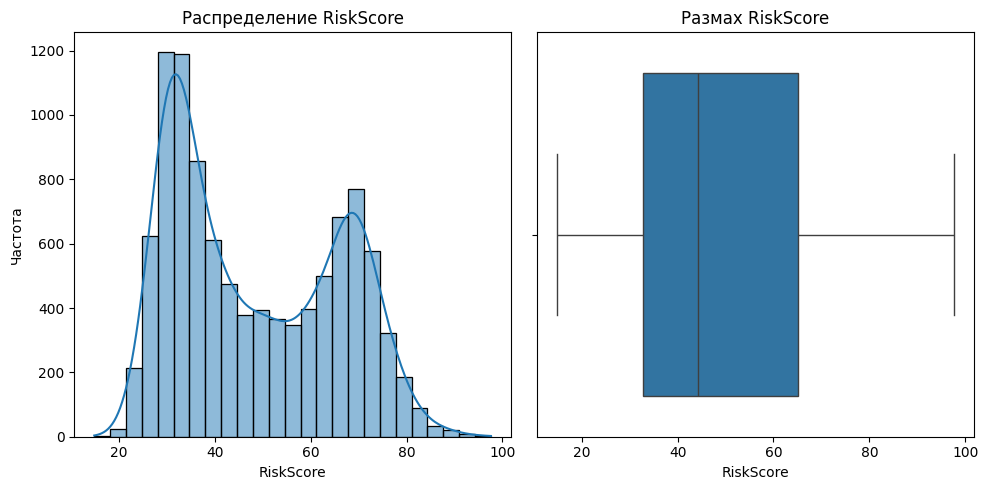

In [986]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df['RiskScore'], kde=True, bins=25)
plt.title('Распределение RiskScore')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['RiskScore'])
plt.title('Размах RiskScore')

plt.tight_layout()
plt.show()

Теперь остальные столбцы с пустыми значениями дополним средним. Для начала разобьём их на категории (числовые и категориальные)

In [987]:
numeric_features = train_df.drop(columns=['RiskScore']).select_dtypes(np.number).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Числовые признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
Категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


In [988]:
# Заполнение средним по столбцу для числовых
train_df[numeric_features] = train_df[numeric_features].fillna(
    train_df[numeric_features].mean()
)
# Модальное заполнение для категориальных
for feat in categorical_features:
    train_df[feat] = train_df[feat].fillna(
        train_df[feat].mode()[0]
    )
initial_rows = len(train_df)
train_df = train_df.drop_duplicates()
print(f"Удалено дубликатов в train_df: {initial_rows - len(train_df)}")

Удалено дубликатов в train_df: 484


In [989]:
print("Пропуски в train_df:")
train_df.isnull().sum()

Пропуски в train_df:


ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
EmploymentStatus              0
EducationLevel                0
Experience                    0
NetWorth                      0
BaseInterestRate              0
InterestRate                  0
MonthlyLoanPayment            0
TotalDebtToIncomeRatio        0
LoanApproved                  0
RiskScore                     0
dtype: int64

Продолжая подготовку данных, переведём наши категориальные признаки в числовые. Для начала посмотрим сколько уникальных значений, у категориальных признаков.

In [990]:
train_df[categorical_features].nunique()

ApplicationDate        9788
MaritalStatus             4
HomeOwnershipStatus       4
LoanPurpose               5
EmploymentStatus          3
EducationLevel            5
dtype: int64

У ApplicationDate, очень много уникальных значений, разобьём её на год, месяц, день. То есть вместо 1 категориального, получим 3 числовых.

In [991]:
train_df = train_df.copy()
train_df['ApplicationDate'] = pd.to_datetime(train_df['ApplicationDate'])

train_df['Application_Year'] = train_df['ApplicationDate'].dt.year
train_df['Application_Month'] = train_df['ApplicationDate'].dt.month
train_df['Application_Day'] = train_df['ApplicationDate'].dt.day

train_df = train_df.drop(columns=['ApplicationDate'])


In [992]:
test_df['ApplicationDate'] = pd.to_datetime(test_df['ApplicationDate'])

test_df['Application_Year'] = test_df['ApplicationDate'].dt.year
test_df['Application_Month'] = test_df['ApplicationDate'].dt.month
test_df['Application_Day'] = test_df['ApplicationDate'].dt.day

test_df = test_df.drop(columns=['ApplicationDate'])

In [993]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']

for col in categorical_cols:
    unique_values = train_df[col].unique()
    print(f"\n{col}")
    print(f"Уникальные значения ({unique_values}")


MaritalStatus
Уникальные значения (['Divorced' 'Widowed' 'Married' 'Single']

HomeOwnershipStatus
Уникальные значения (['Rent' 'Mortgage' 'Other' 'Own']

LoanPurpose
Уникальные значения (['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']

EmploymentStatus
Уникальные значения (['Employed' 'Self-Employed' 'Unemployed']

EducationLevel
Уникальные значения (['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


Признаки номинальные (не имеют никакого порядка по значениям). Значит можно применить метод One-hot-encoding.

In [994]:
def one_hot_encoding(df, categorical_cols):
    temp = df.copy()
    dummies = pd.get_dummies(temp[categorical_cols],
                              prefix=categorical_cols,
                             dtype='int8')

    result = pd.concat([temp.drop(columns=categorical_cols), dummies], axis=1)
    return result

In [995]:
categorical_cols = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose',
                   'EmploymentStatus', 'EducationLevel']

train_df = one_hot_encoding(train_df, categorical_cols)
test_df = one_hot_encoding(test_df, categorical_cols)

train_df.head()


Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0  27.0       66829.0        549.0     17290.0          60.0   
1  55.0      172147.0        850.0     16110.0          36.0   
2  51.0      300000.0        850.0     38436.0          36.0   
3  25.0       34683.0        847.0     19186.0          48.0   
4  55.0      300000.0        850.0     30437.0          48.0   

   NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
0                 1.0               1095.0                   0.151985   
1                 1.0                211.0                   0.175693   
2                 0.0                546.0                   0.444605   
3                 0.0                153.0                   0.188452   
4                 2.0                562.0                   0.273431   

   NumberOfOpenCreditLines  NumberOfCreditInquiries  ...  LoanPurpose_Home  \
0                      2.0                      1.0  ...                 0   
1                      3.0                      0.0  ...                 1   
2                      3.0                      0.0  ...                 0   
3                      7.0                      0.0  ...                 0   
4                      3.0                      1.0  ...                 0   

   LoanPurpose_Other  EmploymentStatus_Employed  \
0                  0                          1   
1                  0                          1   
2                  0                          1   
3                  0                          1   
4                  0                          1   

   EmploymentStatus_Self-Employed  EmploymentStatus_Unemployed  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   EducationLevel_Associate  EducationLevel_Bachelor  \
0                         1                        0   
1                         0                        0   
2                         0                        1   
3                         0                        0   
4                         0                        1   

   EducationLevel_Doctorate  EducationLevel_High School  EducationLevel_Master  
0                         0                           0                      0  
1                         0                           1                      0  
2                         0                           0                      0  
3                         0                           1                      0  
4                         0                           0                      0  

[5 rows x 54 columns]

Теперь все признаки в наших даннах числовые.

# Графики зависимостей признаков от частоты

In [996]:
def plot_distribution(df, column_name, bins=25, figsize=(10, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True, bins=bins)
    plt.title(f'Распределение {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column_name])
    plt.title(f'Размах {column_name}')
    plt.xlabel(column_name)

    plt.tight_layout()
    plt.show()

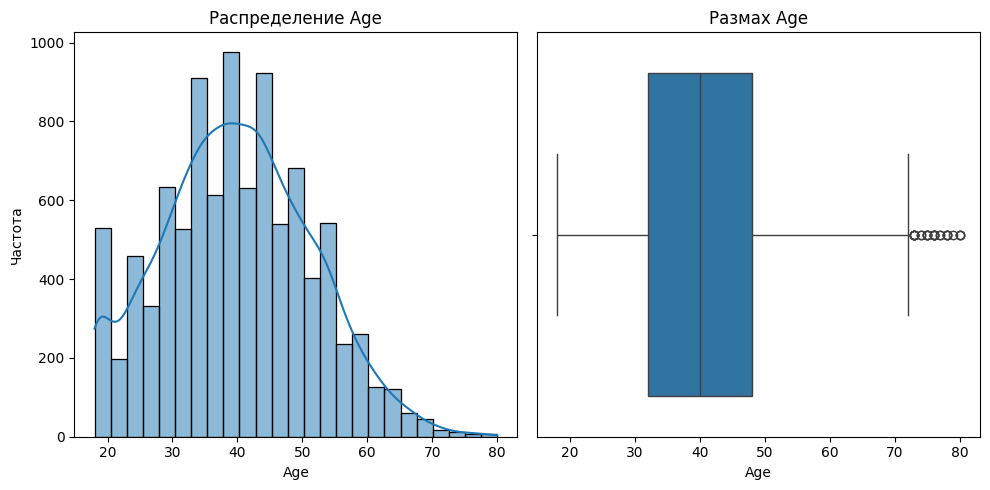

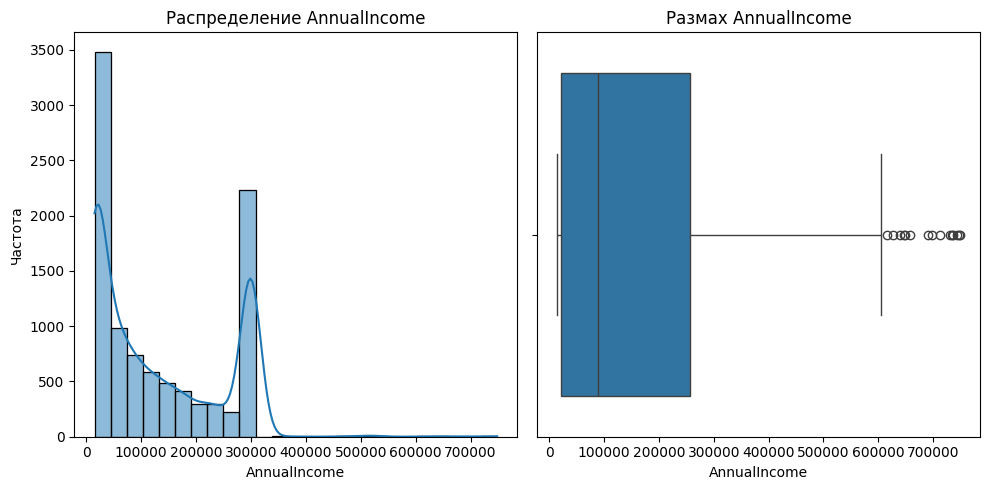

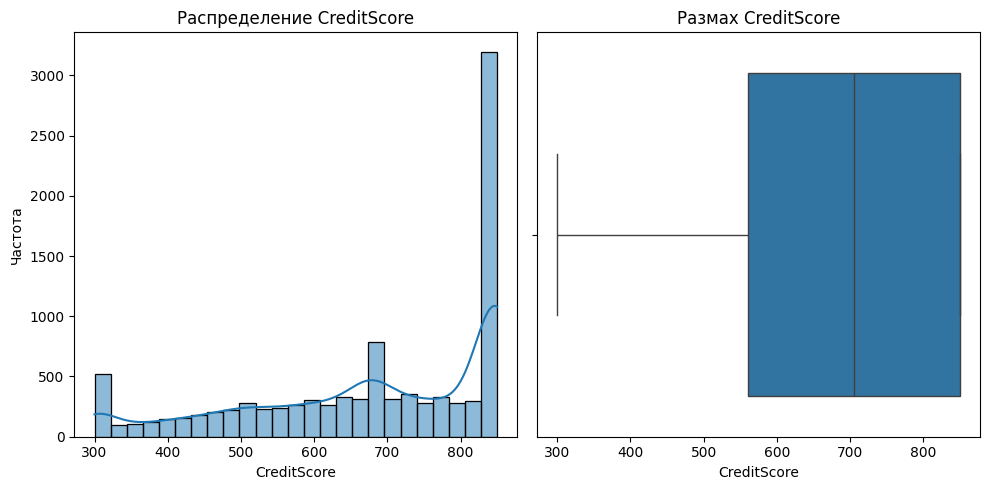

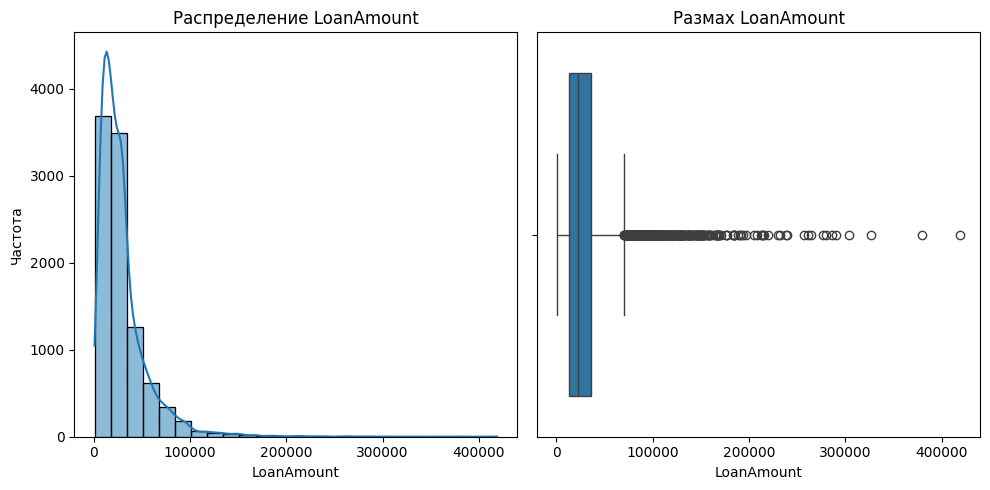

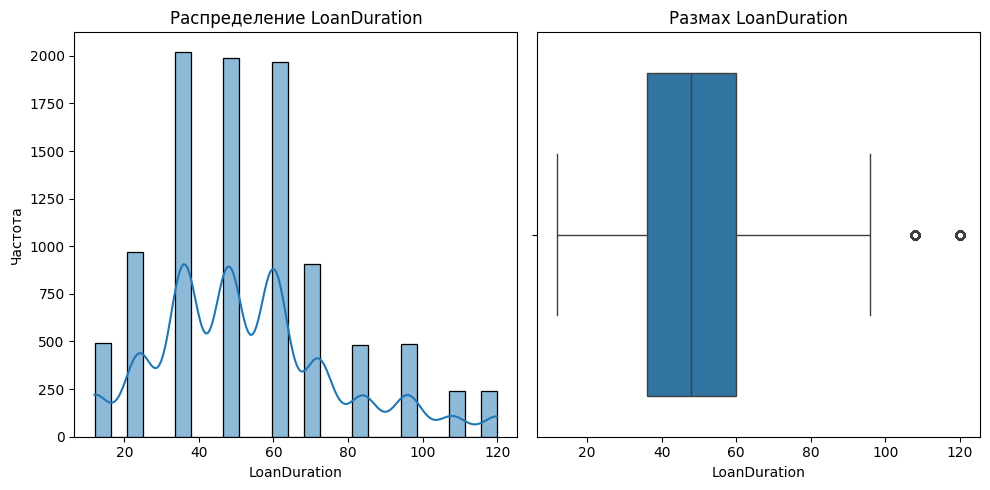

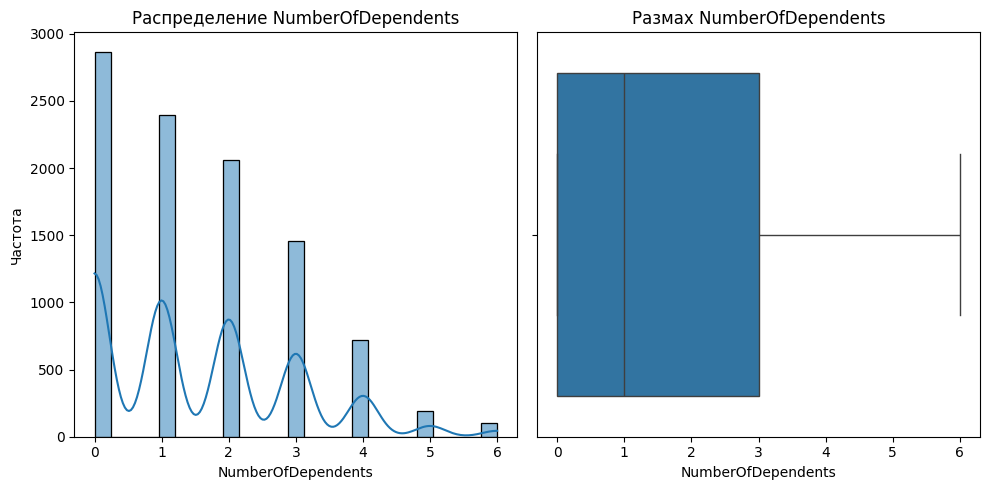

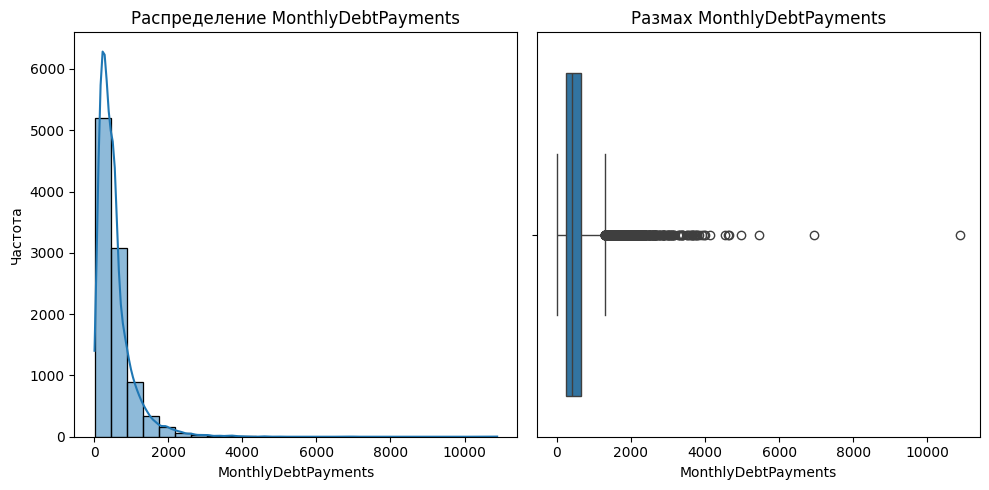

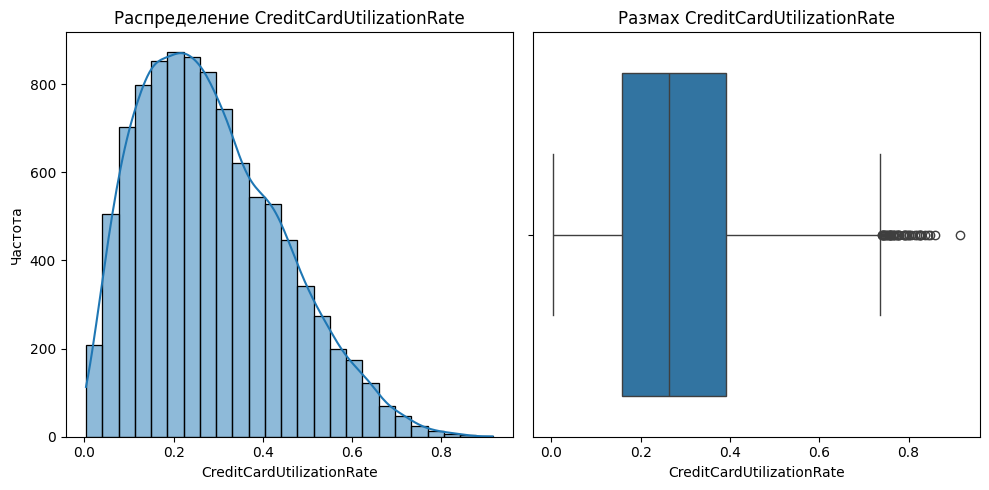

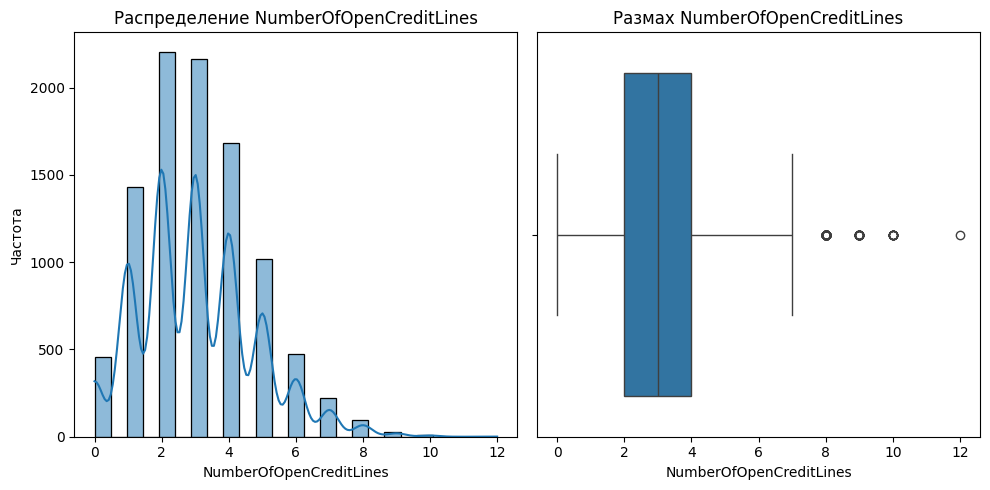

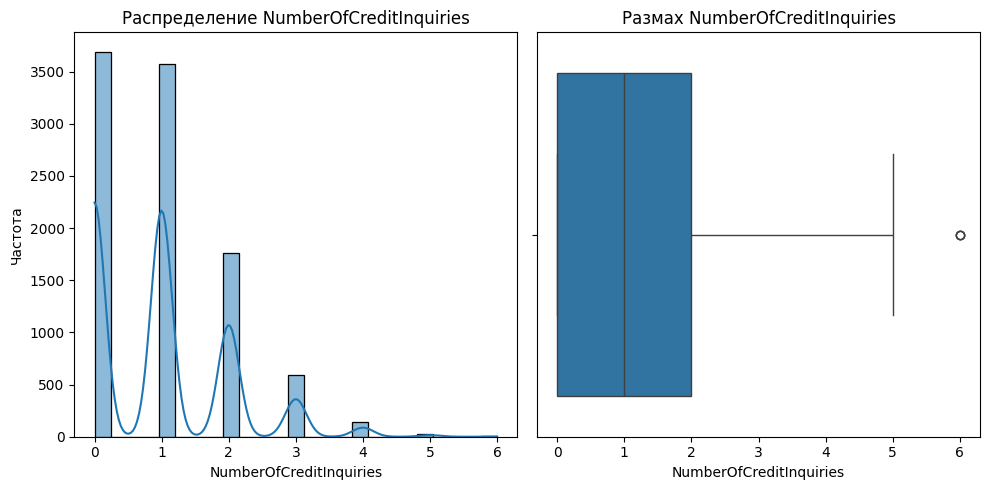

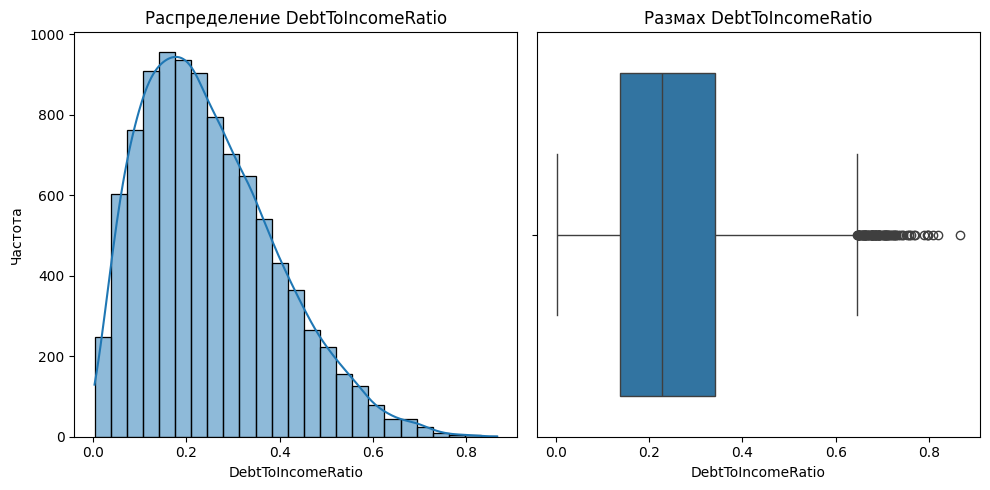

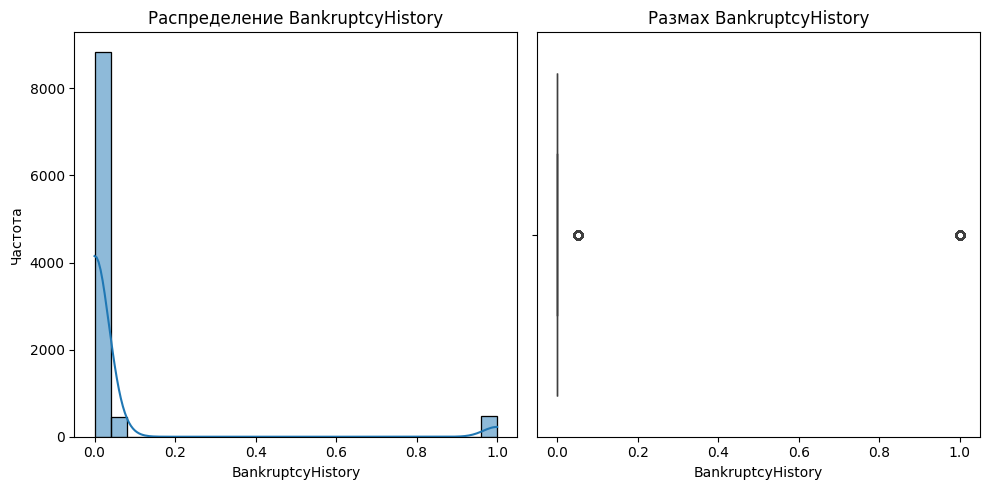

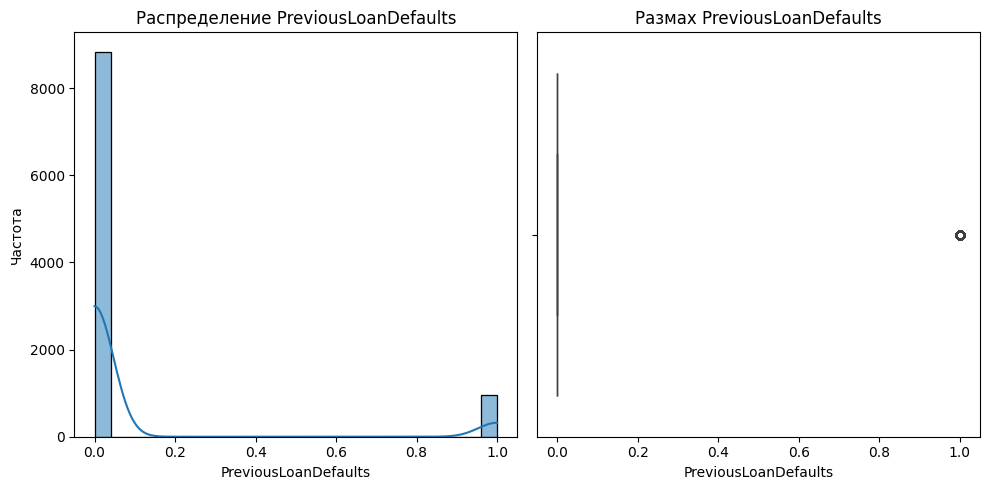

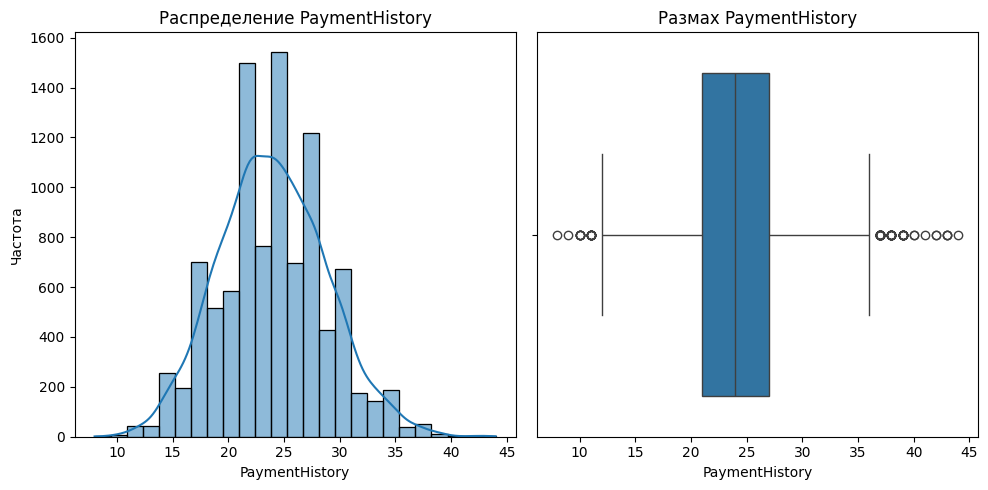

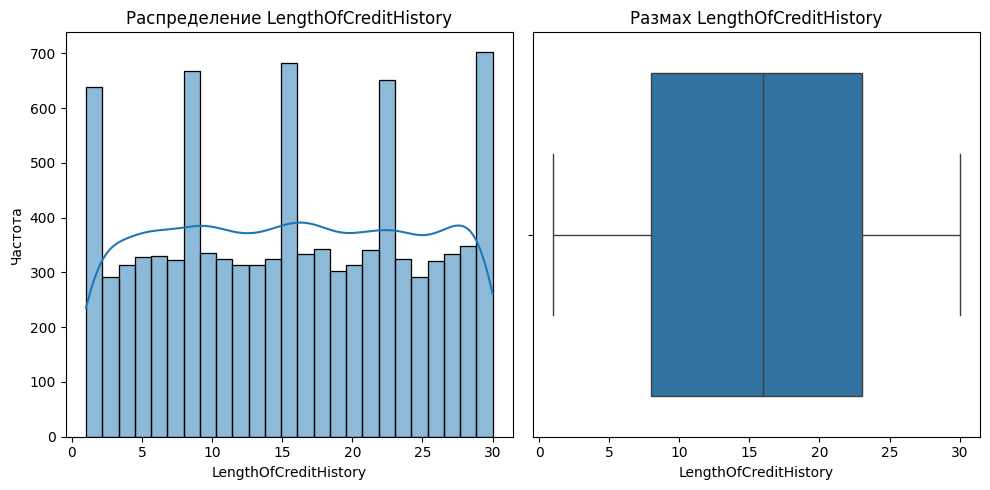

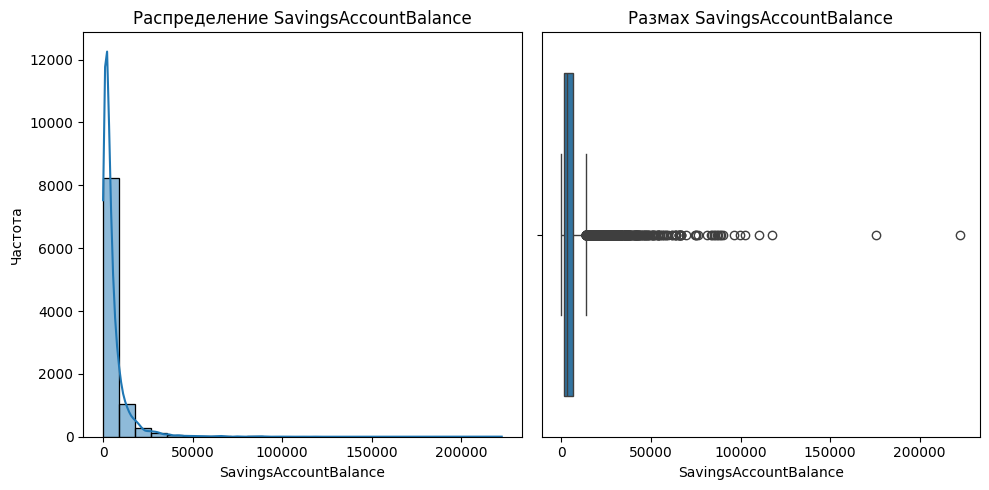

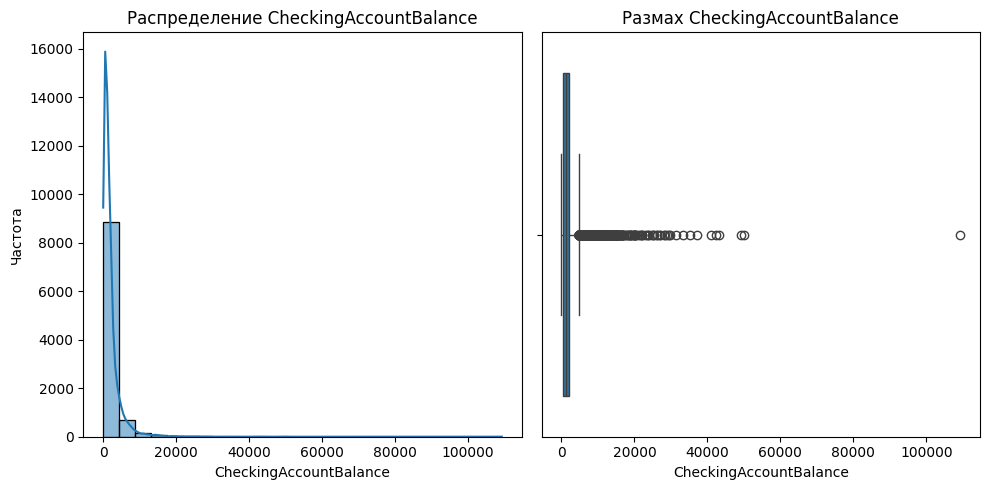

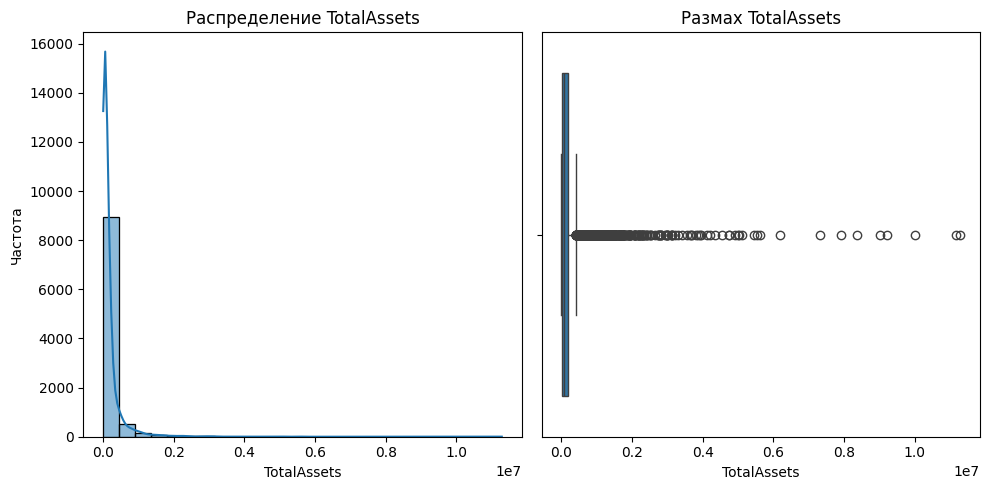

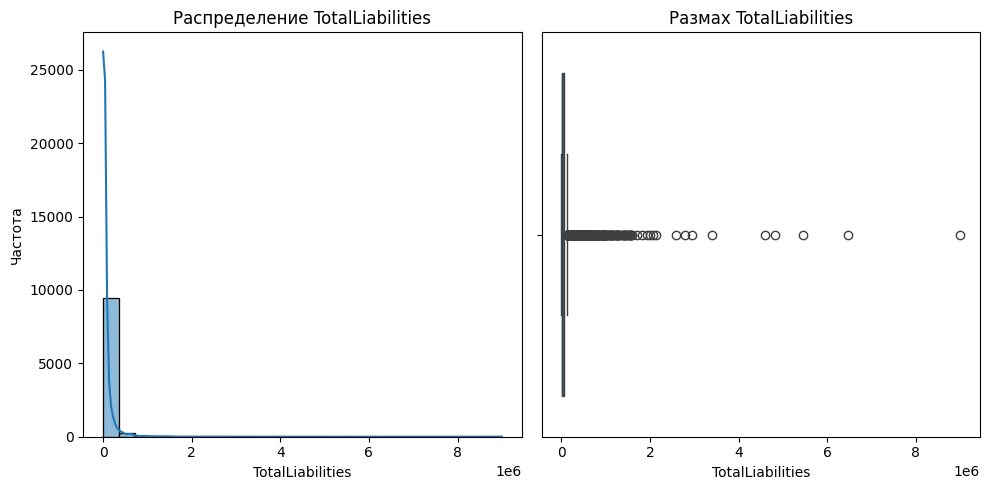

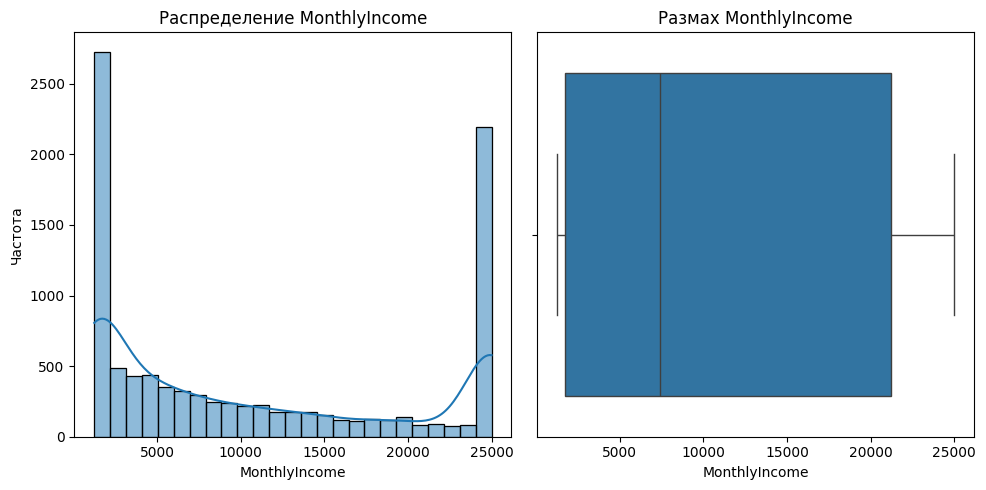

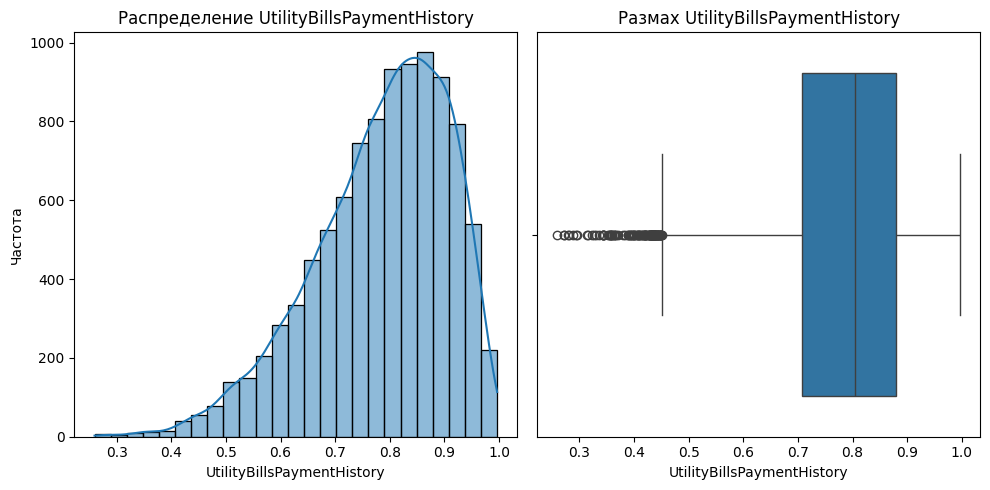

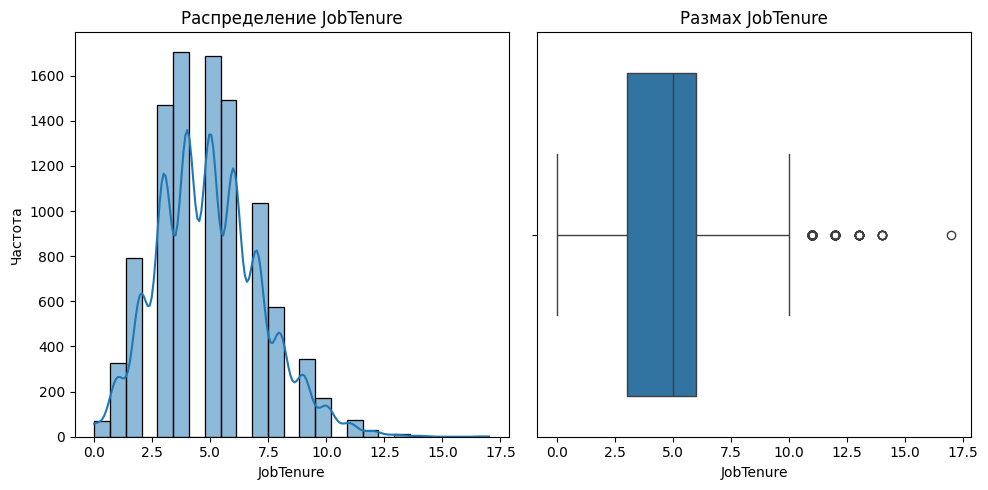

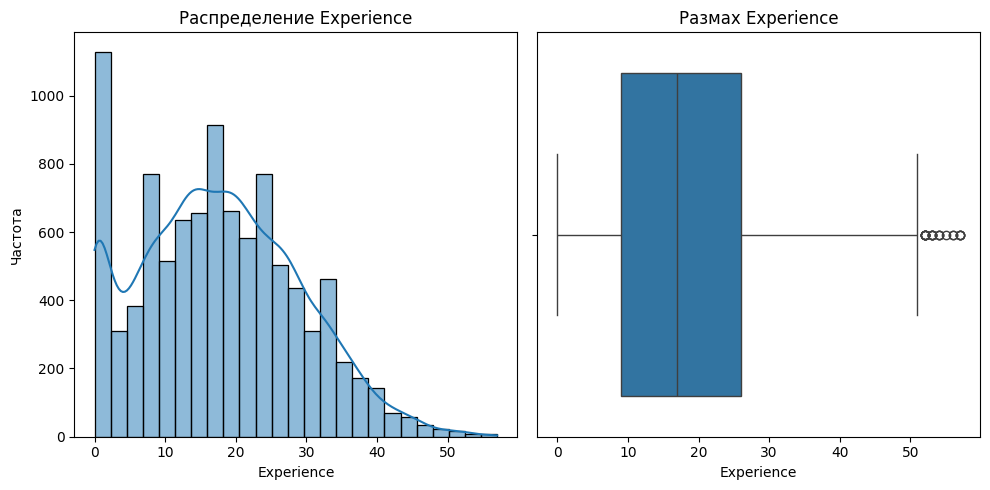

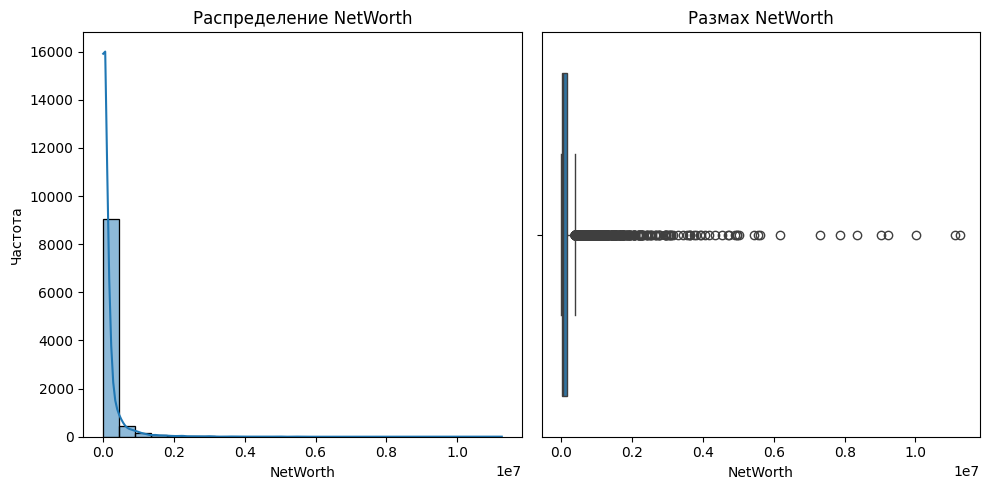

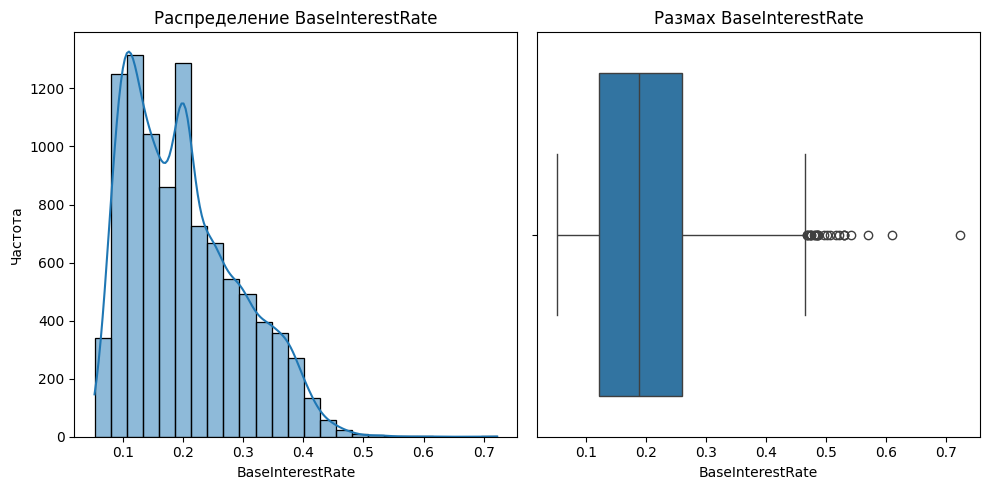

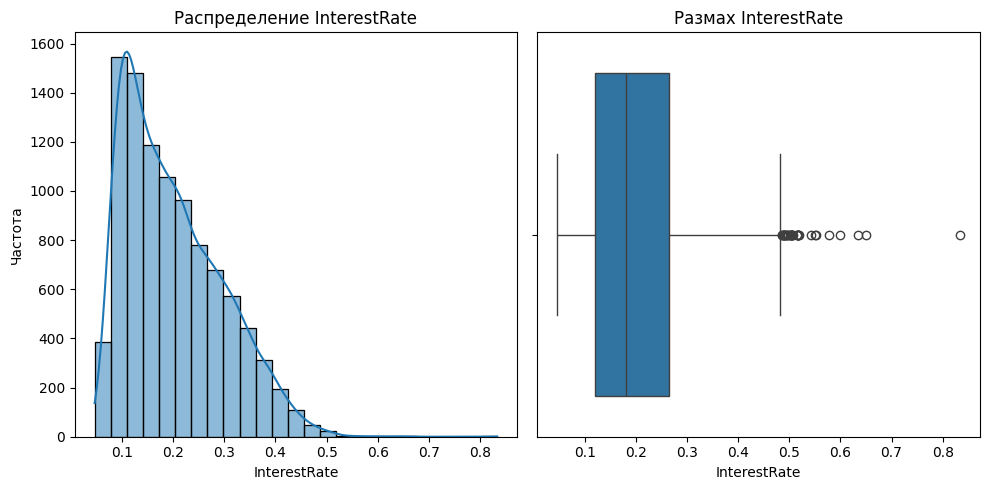

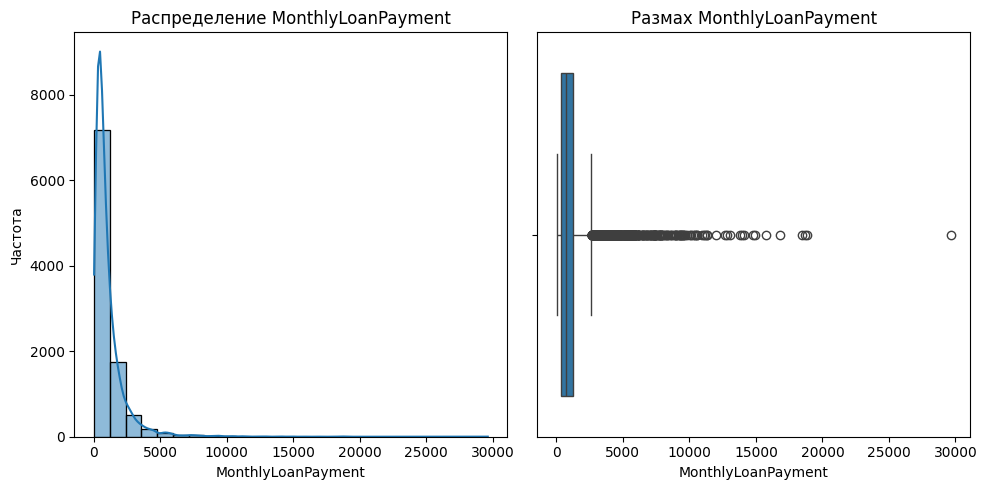

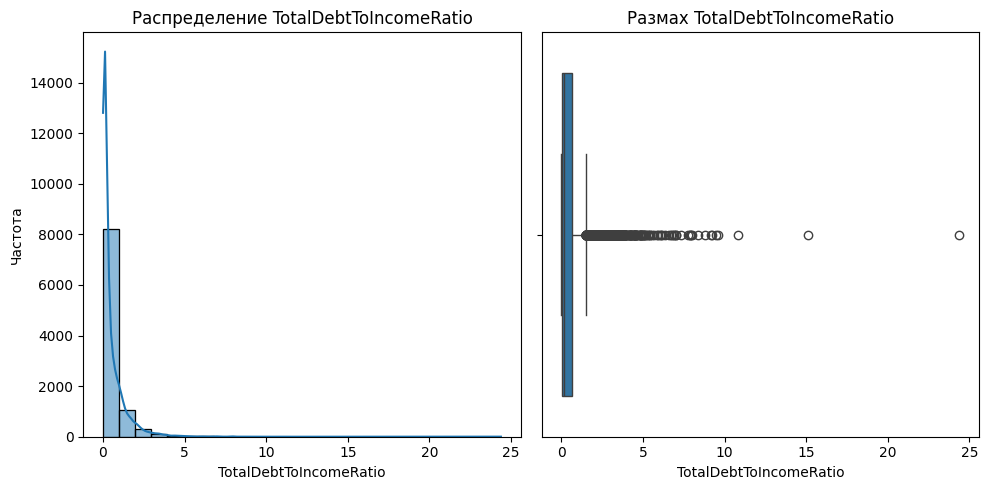

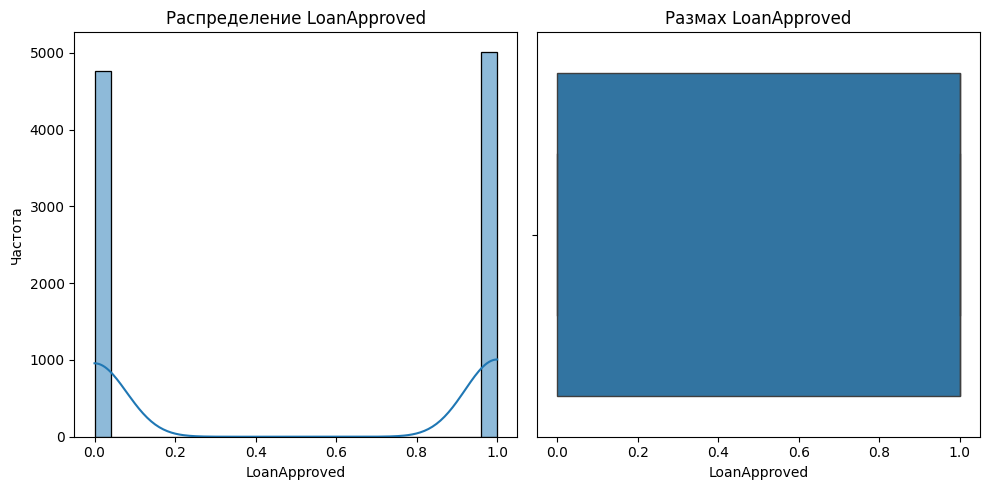

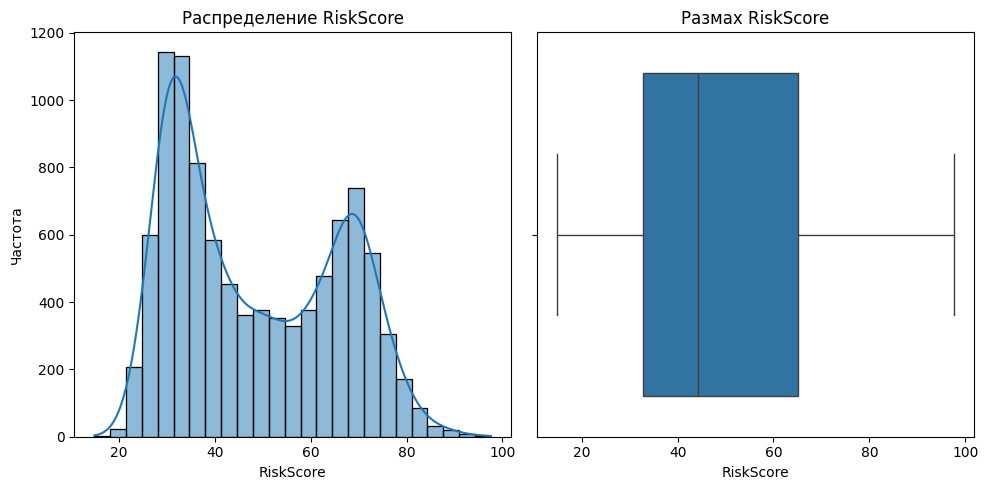

In [997]:
numeric_features = [col for col in train_df.select_dtypes(np.number).columns
                   if '_' not in col]
for feature in numeric_features:
    plot_distribution(train_df, feature)

# Продолжение обработки данных, матрица корреляций, зависимости.

In [998]:
copy_train_df = train_df.copy()
copy_test_df = test_df.copy()

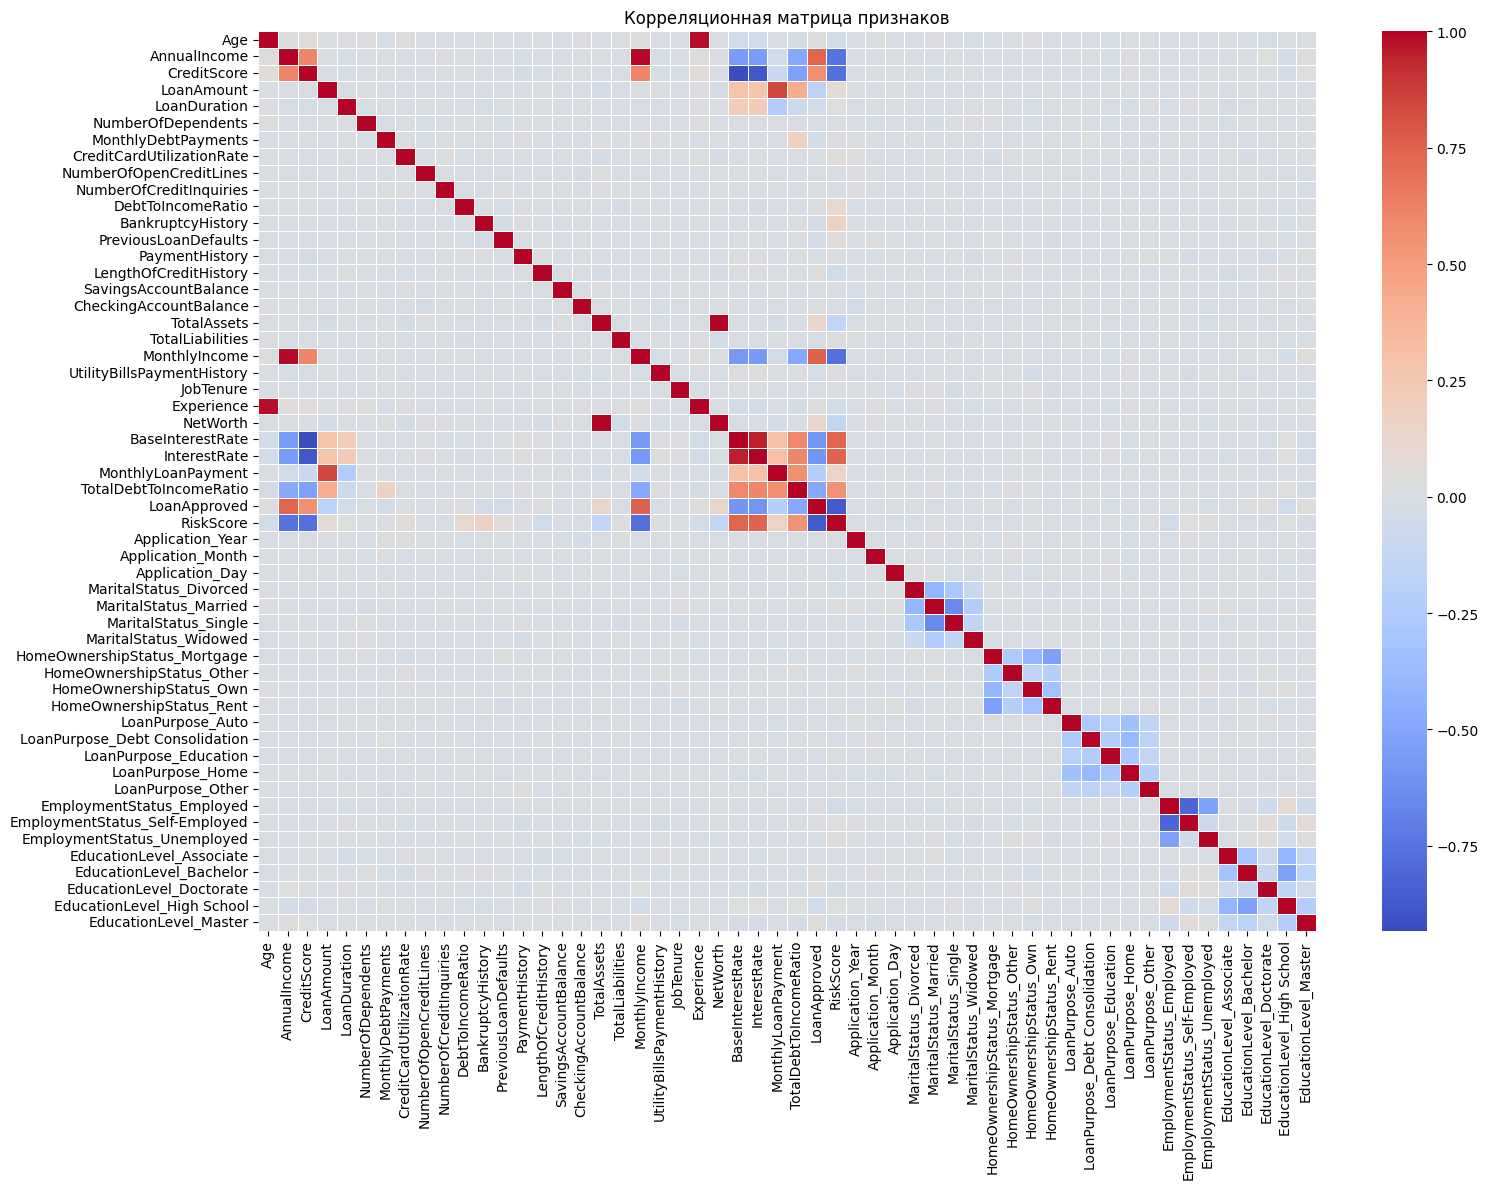

In [999]:
corr_matrix = copy_train_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=False,
            fmt='.2f',
            linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

Нормализуем все признаки с помощью Yeo-Johnson трансформации.

Посмотрим ещё раз на матрицу корреляции.

In [1000]:
from scipy import stats

numeric_cols = copy_train_df.drop(columns=['RiskScore']) \
                   .select_dtypes(include=np.number).columns

for col in numeric_cols:
    x_train = copy_train_df[col].values.copy()
    x_test = copy_test_df[col].values.copy()

    if np.any(x_train <= 0):
        shift = abs(np.min(x_train)) + 1e-6
        x_train = x_train + shift
        x_test = x_test + shift

    x_train_bc, lam = stats.yeojohnson(x_train)
    x_test_bc = stats.yeojohnson(x_test, lam)

    copy_train_df[col] = x_train_bc
    copy_test_df[col] = x_test_bc

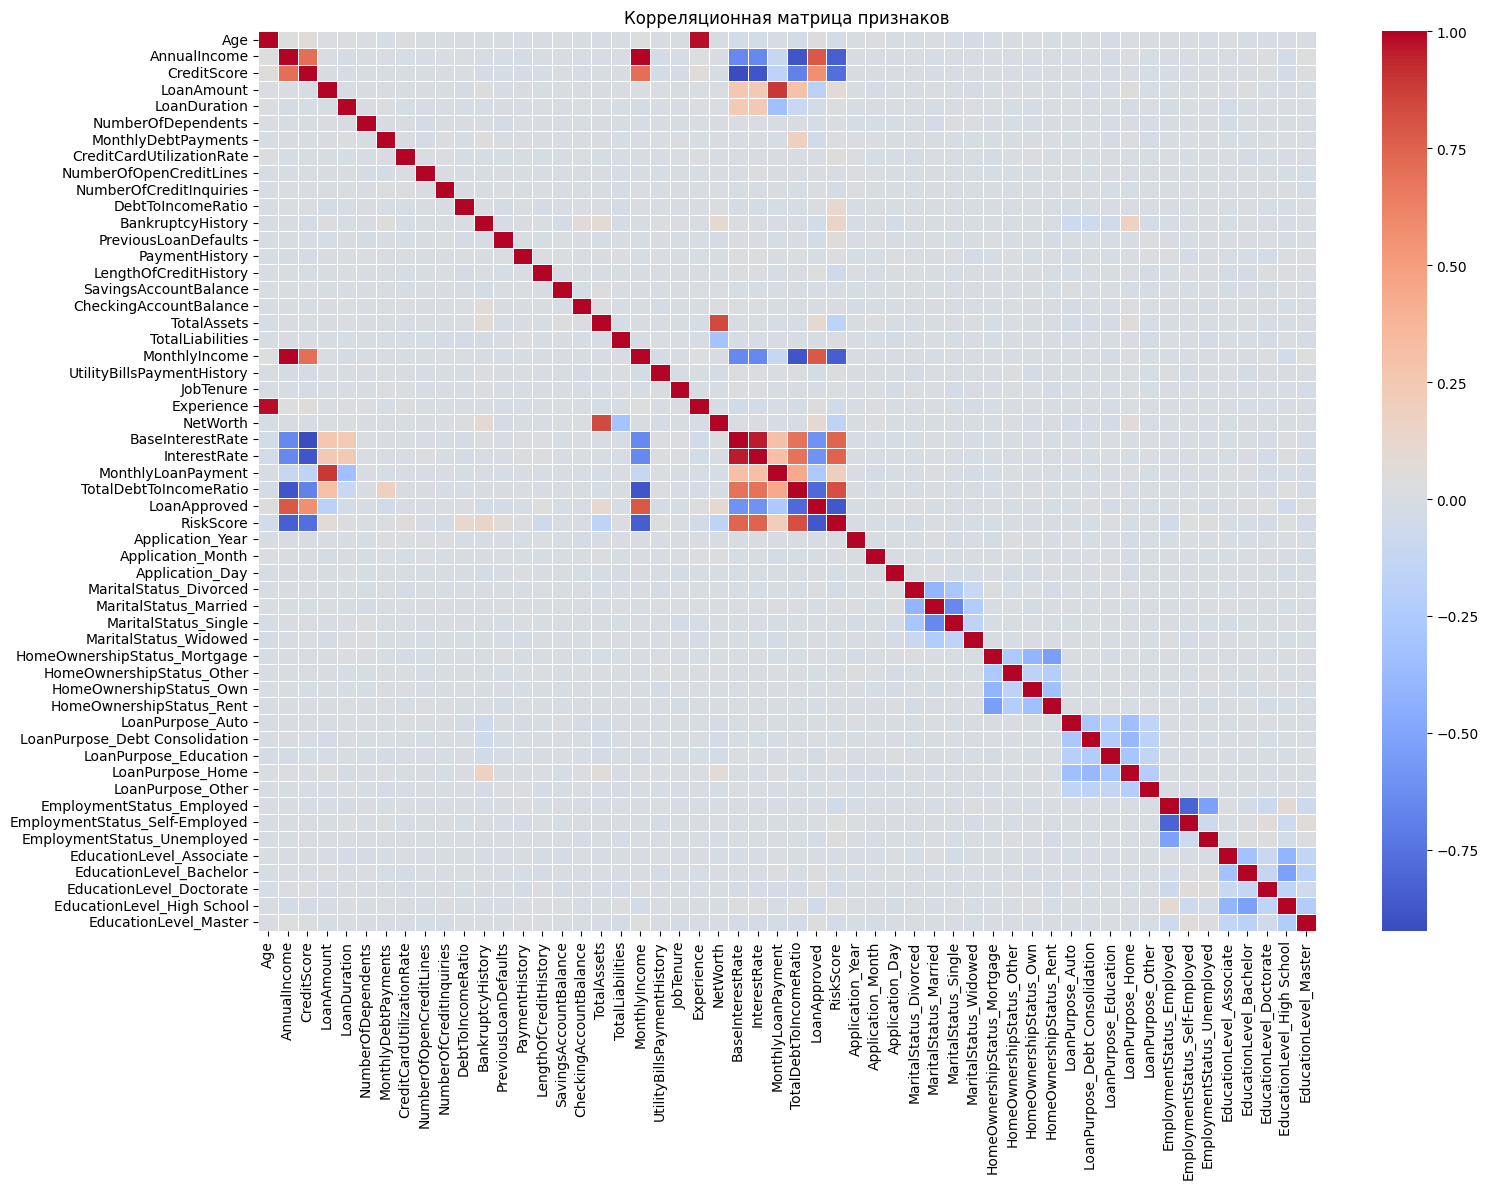

In [1001]:
corr_matrix = copy_train_df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            annot=False,
            fmt='.2f',
            linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

Чтобы избежать мультиколлинеарности, рассмотрим наиболее коррелирующие признаки и проведём анализ.

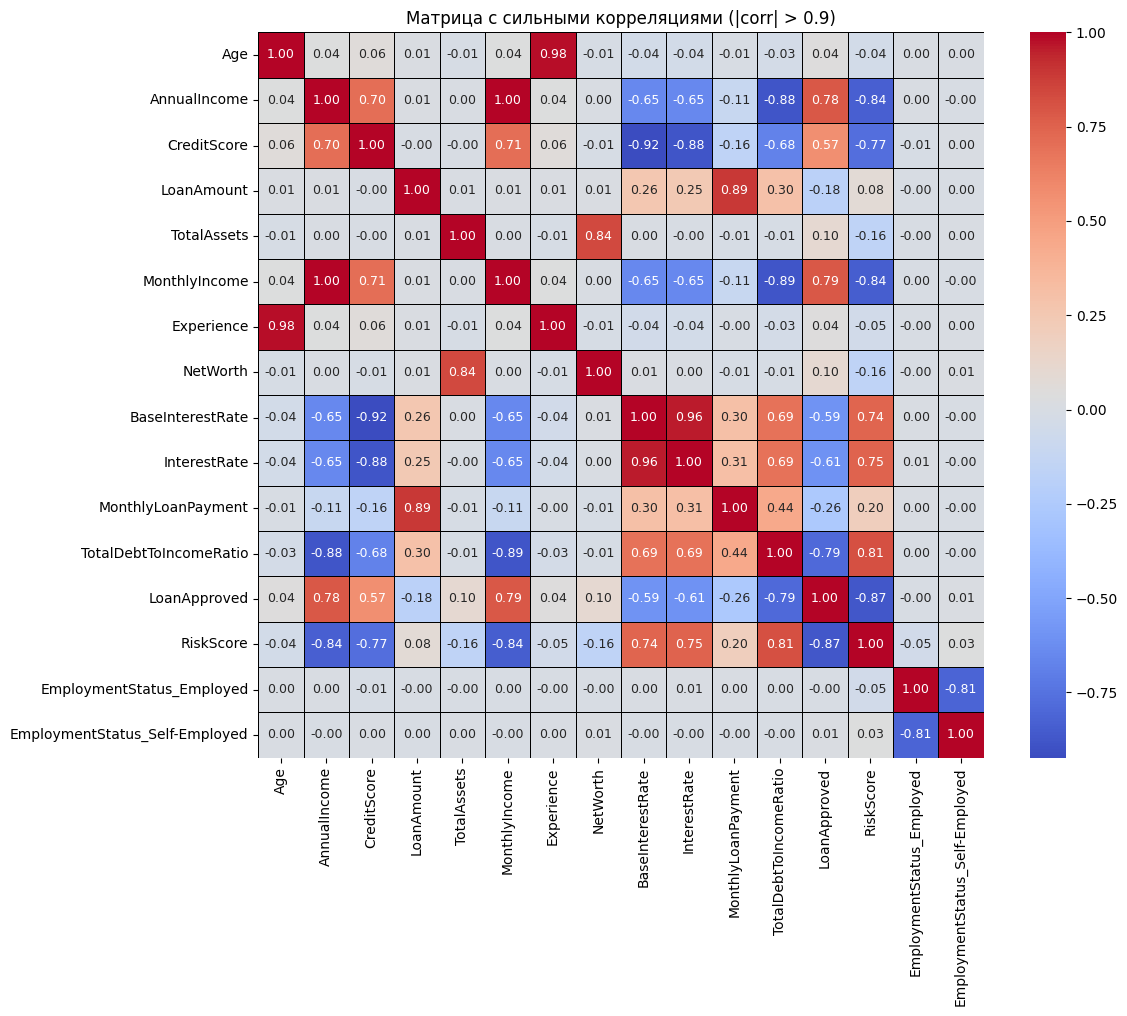

In [1002]:
np.fill_diagonal(corr_matrix.values, 0)
high_corr_features = corr_matrix.columns[(np.abs(corr_matrix) > 0.7).any()]
filtered_corr = corr_matrix.loc[high_corr_features, high_corr_features]
np.fill_diagonal(filtered_corr.values, 1)

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr,
            cmap='coolwarm',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            linecolor='black',
            square=True,
            cbar=True,
            annot_kws={"size": 9})

plt.title('Матрица с сильными корреляциями (|corr| > 0.9)')
plt.tight_layout()
plt.show()

По матрице видно, что у нас есть 2 максимально коррелирующих признака (Age:Experience, MonthlyLoanPayment:LoanAmount, EmploymentStatus_Employed:EmploymentStatus_Self-Employed), наименее коррелирующие с RiskScore

Будем оставлять те признаки, которые больше всего коррелируют с RiskScore.

In [1003]:
def plot_multiple_correlations(df: pd.DataFrame,
                             correlated_pairs: list,
                             target_col: str = 'RiskScore',
                             figsize: tuple = (15, 8)) -> list:
    n_pairs = len(correlated_pairs)
    cols_to_drop = []

    plt.figure(figsize=figsize)

    for i, (col1, col2) in enumerate(correlated_pairs, 1):
        plt.subplot(1, n_pairs, i)

        corr_matrix = df[[col1, col2, target_col]].corr()

        corr1 = abs(corr_matrix.loc[col1, target_col])
        corr2 = abs(corr_matrix.loc[col2, target_col])

        if corr1 > corr2:
            cols_to_drop.append(col2)
            title = f"Удалить '{col2}'\n({col1}: {corr1:.4f} vs {col2}: {corr2:.4f})"
        else:
            cols_to_drop.append(col1)
            title = f"Удалить '{col1}'\n({col2}: {corr2:.4f} vs {col1}: {corr1:.4f})"

        sns.heatmap(
            corr_matrix,
            cmap='coolwarm',
            annot=True,
            fmt='.4f',
            linewidths=0.5,
            linecolor='black',
            square=True,
            cbar=False,
            annot_kws={"size": 10}
        )
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

    return cols_to_drop

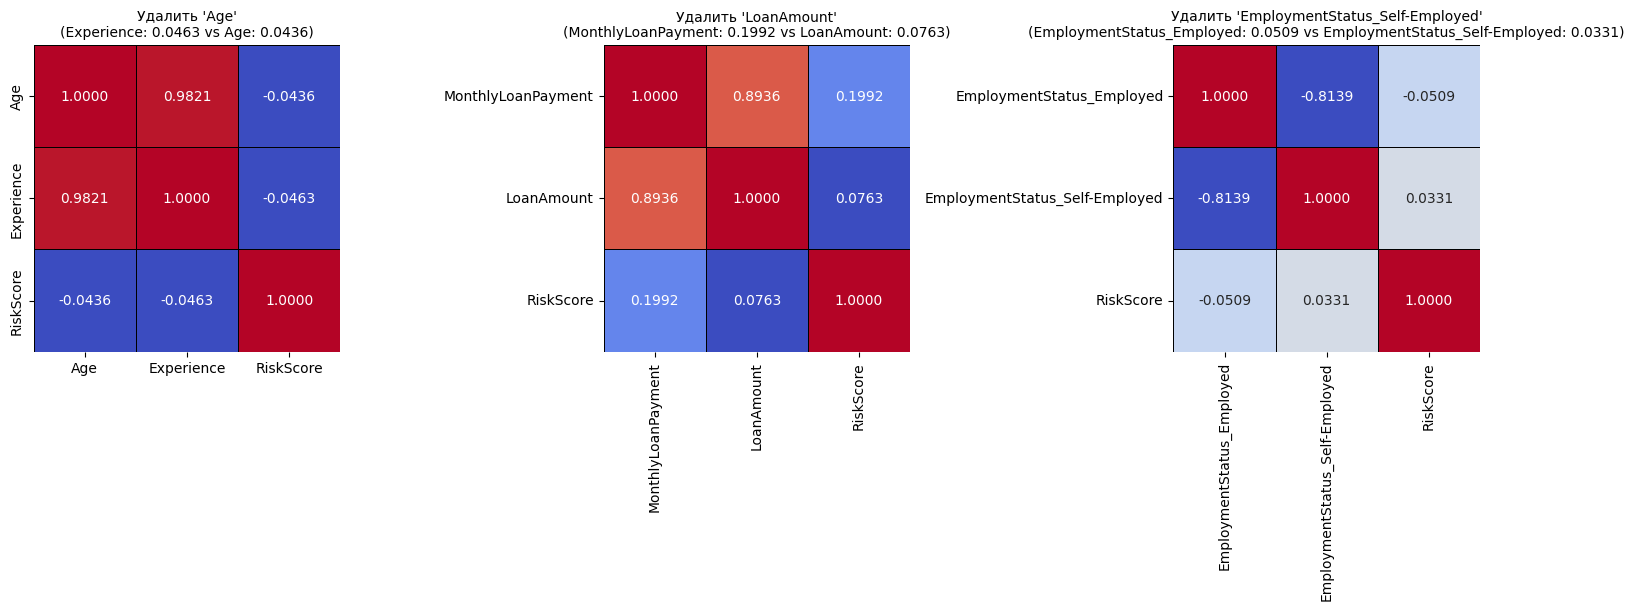


Столбцы для удаления: ['Age', 'LoanAmount', 'EmploymentStatus_Self-Employed']


In [1004]:
correlated_pairs = [
    ('Age', 'Experience'),
    ('MonthlyLoanPayment', 'LoanAmount'),
    ('EmploymentStatus_Employed', 'EmploymentStatus_Self-Employed')
]

cols_to_remove = plot_multiple_correlations(copy_train_df, correlated_pairs)
print(f"\nСтолбцы для удаления: {cols_to_remove}")

In [1005]:
copy_test_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')
copy_train_df.drop(columns=cols_to_remove, inplace=True, errors='ignore')

In [1006]:
copy_train_df.head()

AnnualIncome   CreditScore  LoanDuration  NumberOfDependents  \
0     27.476659  6.132562e+05     11.960537        7.213085e-01   
1     32.506077  1.630171e+06      9.095612        7.213085e-01   
2     35.794221  1.630171e+06      9.095612        9.999996e-07   
3     24.371907  1.617327e+06     10.625374        9.999996e-07   
4     35.794221  1.630171e+06     10.625374        1.170474e+00   

   MonthlyDebtPayments  CreditCardUtilizationRate  NumberOfOpenCreditLines  \
0             7.857078                   0.129844                 1.467496   
1             5.849755                   0.146744                 2.005979   
2             6.994852                   0.295788                 2.005979   
3             5.471475                   0.155529                 3.674088   
4             7.030237                   0.209053                 2.005979   

   NumberOfCreditInquiries  DebtToIncomeRatio  BankruptcyHistory  ...  \
0             6.495133e-01           0.136554       9.999881e-07  ...   
1             9.999994e-07           0.118336       9.999881e-07  ...   
2             9.999994e-07           0.029726       4.378036e-02  ...   
3             9.999994e-07           0.246929       9.999881e-07  ...   
4             6.495133e-01           0.062736       9.999881e-07  ...   

   LoanPurpose_Education  LoanPurpose_Home  LoanPurpose_Other  \
0           1.069933e-01      9.999979e-07       9.999915e-07   
1           9.999948e-07      2.800989e-01       9.999915e-07   
2           1.069933e-01      9.999979e-07       9.999915e-07   
3           9.999948e-07      9.999979e-07       9.999915e-07   
4           9.999948e-07      9.999979e-07       9.999915e-07   

   EmploymentStatus_Employed  EmploymentStatus_Unemployed  \
0                 147.690205                 9.999821e-07   
1                 147.690205                 9.999821e-07   
2                 147.690205                 9.999821e-07   
3                 147.690205                 9.999821e-07   
4                 147.690205                 9.999821e-07   

   EducationLevel_Associate  EducationLevel_Bachelor  \
0              1.398170e-01             9.999975e-07   
1              9.999959e-07             9.999975e-07   
2              9.999959e-07             2.353627e-01   
3              9.999959e-07             9.999975e-07   
4              9.999959e-07             2.353627e-01   

   EducationLevel_Doctorate  EducationLevel_High School  EducationLevel_Master  
0              9.999778e-07                9.999986e-07           9.999896e-07  
1              9.999778e-07                4.060229e-01           9.999896e-07  
2              9.999778e-07                9.999986e-07           9.999896e-07  
3              9.999778e-07                4.060229e-01           9.999896e-07  
4              9.999778e-07                9.999986e-07           9.999896e-07  

[5 rows x 51 columns]

# Графики распределения признаков, после преобразований (нормализации).

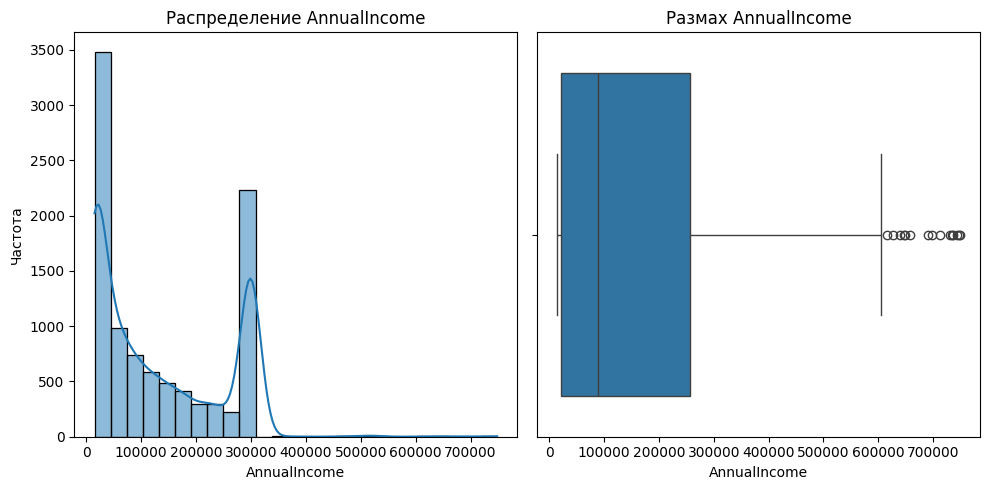

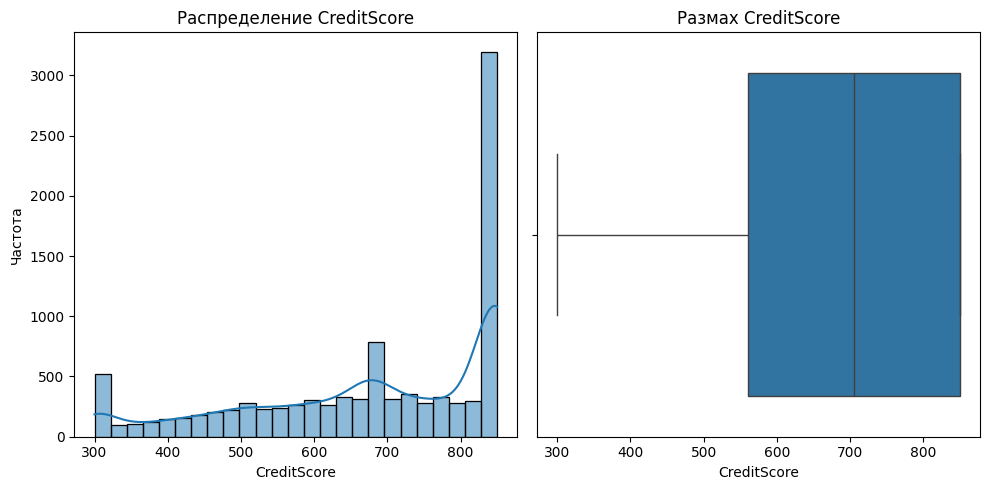

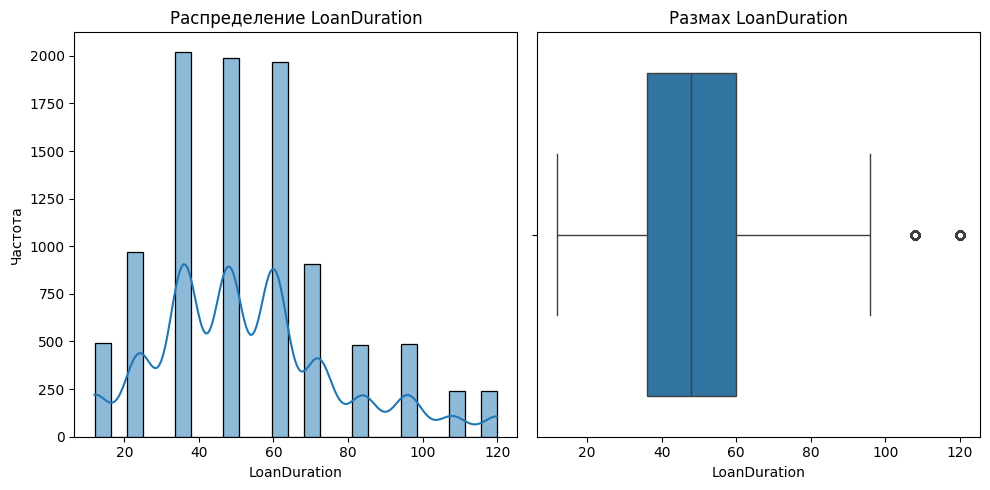

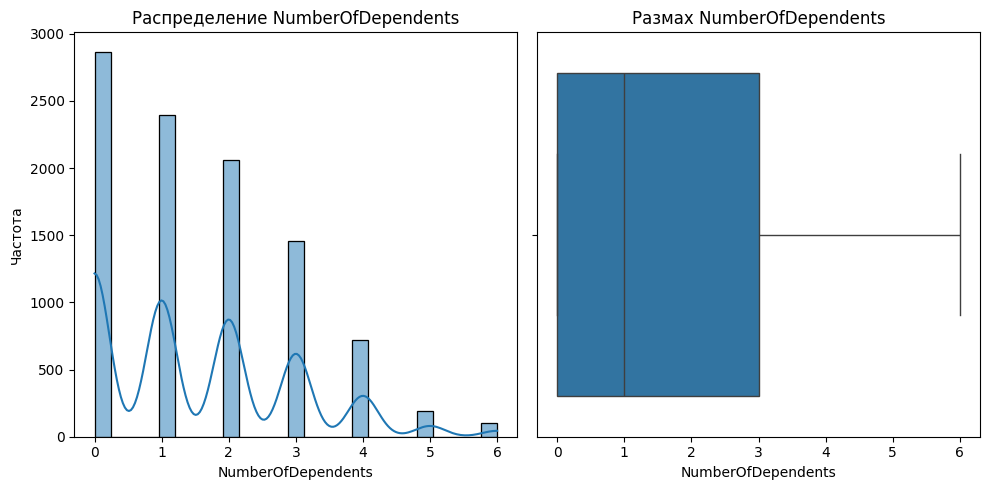

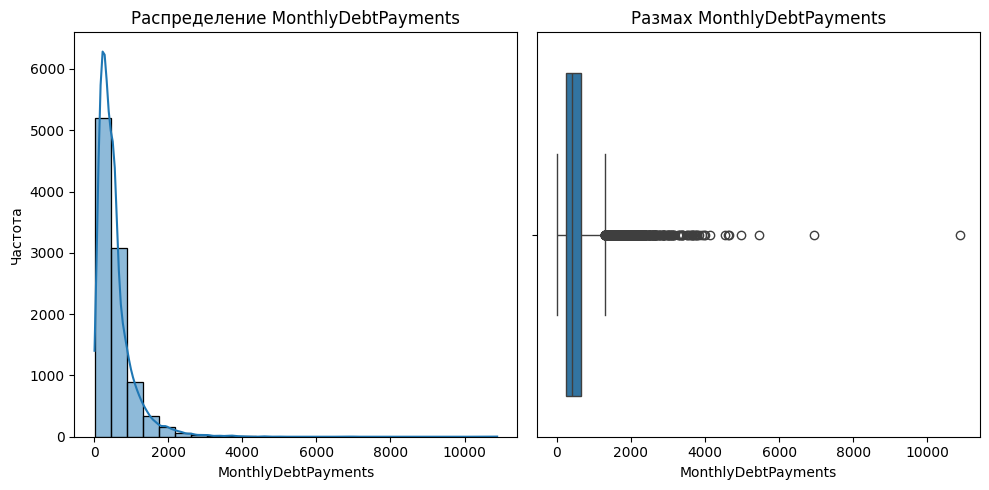

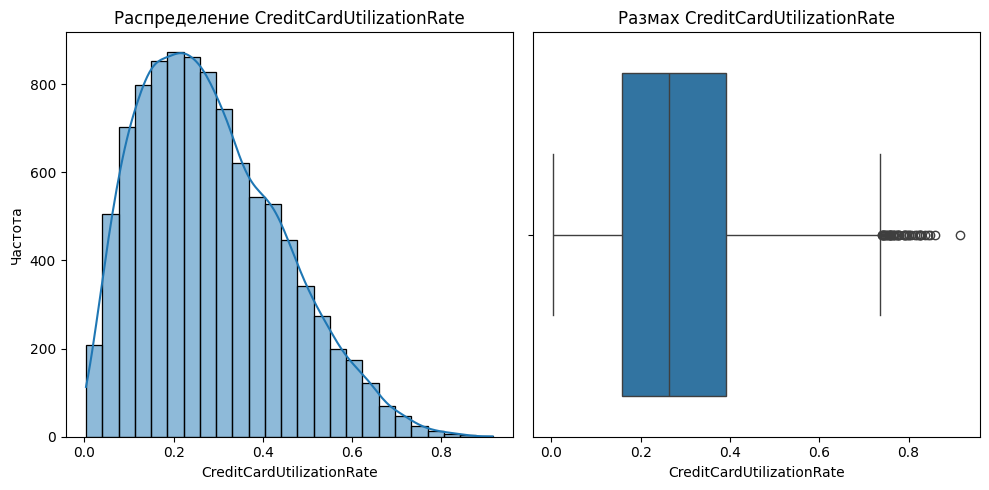

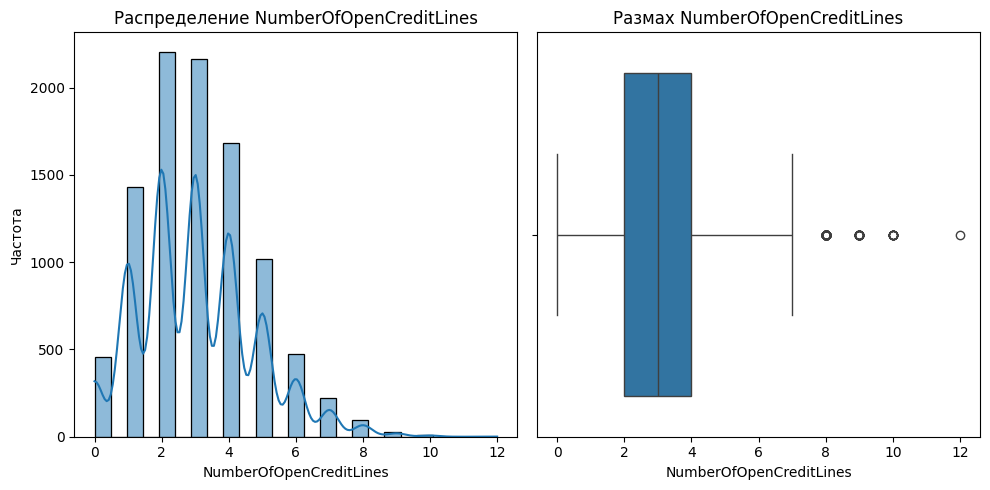

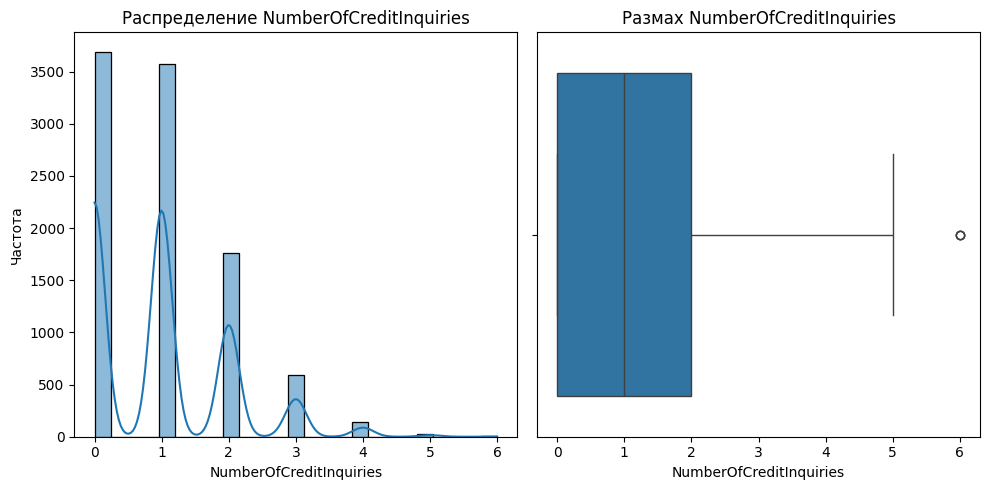

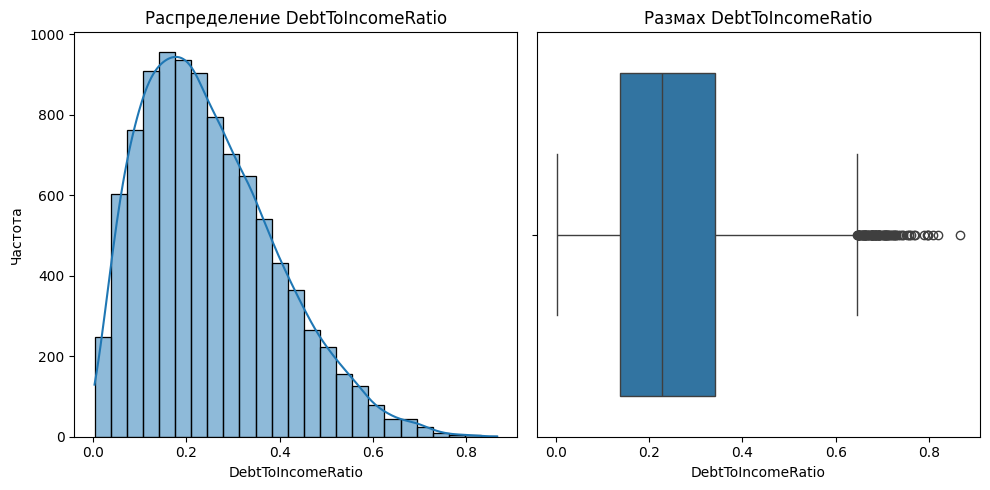

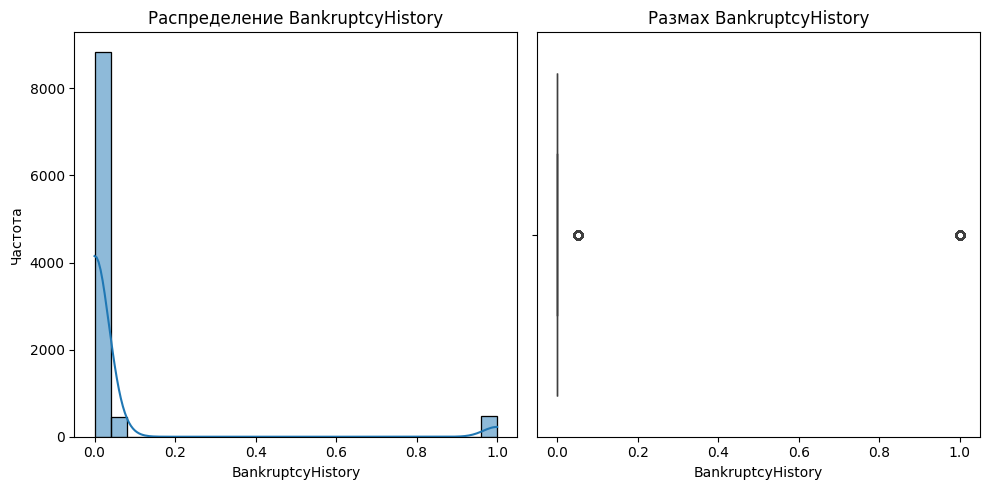

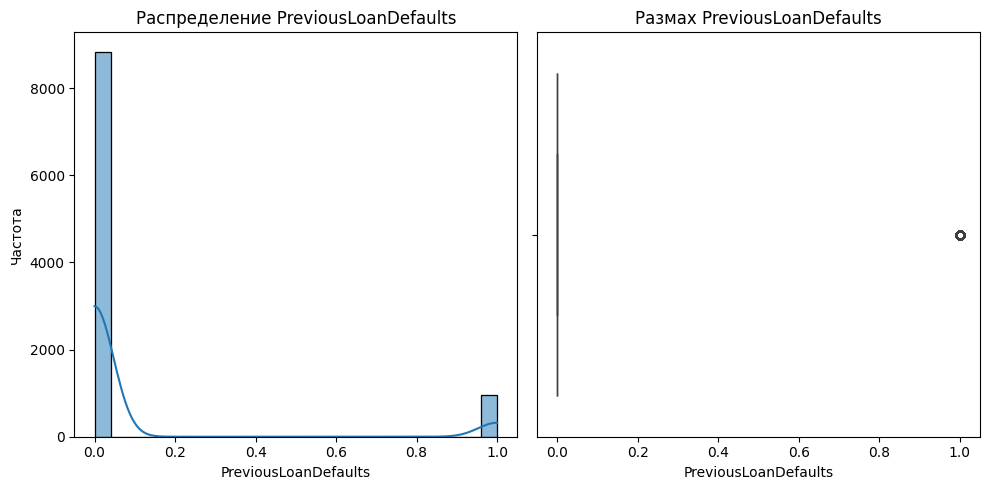

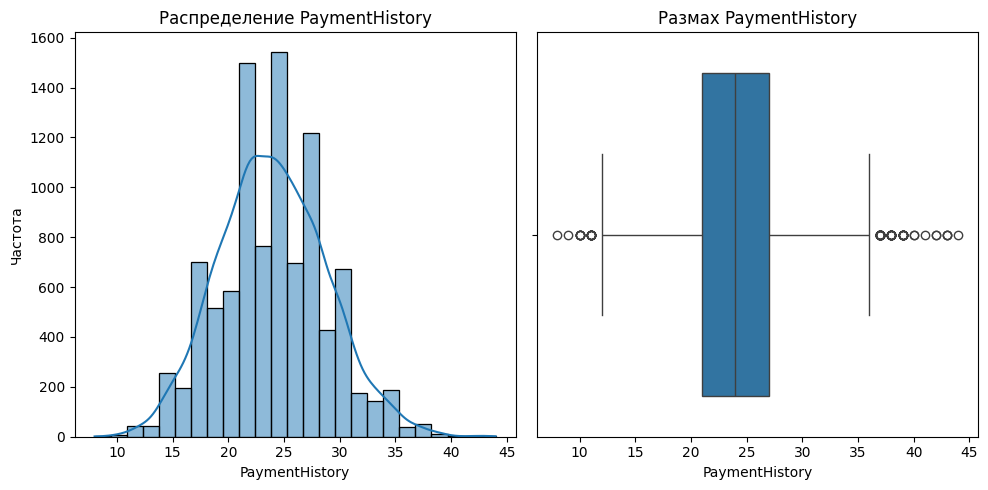

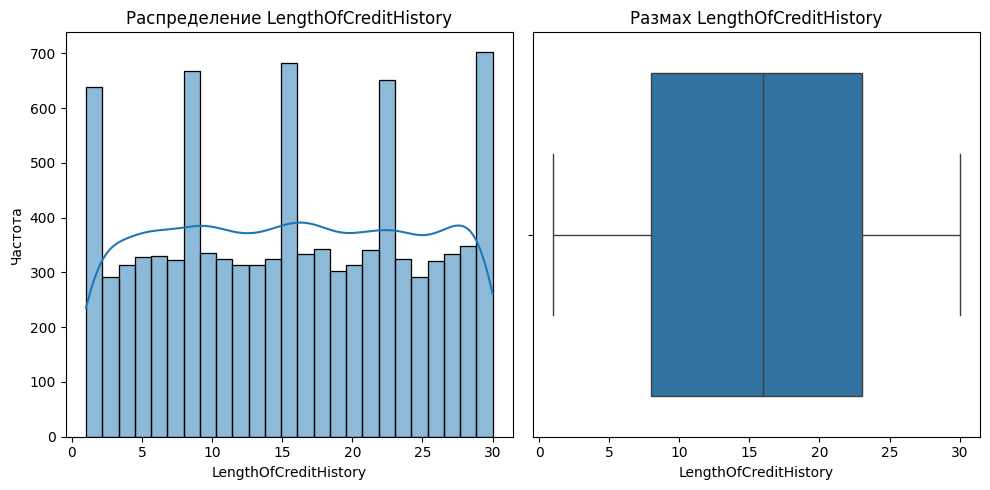

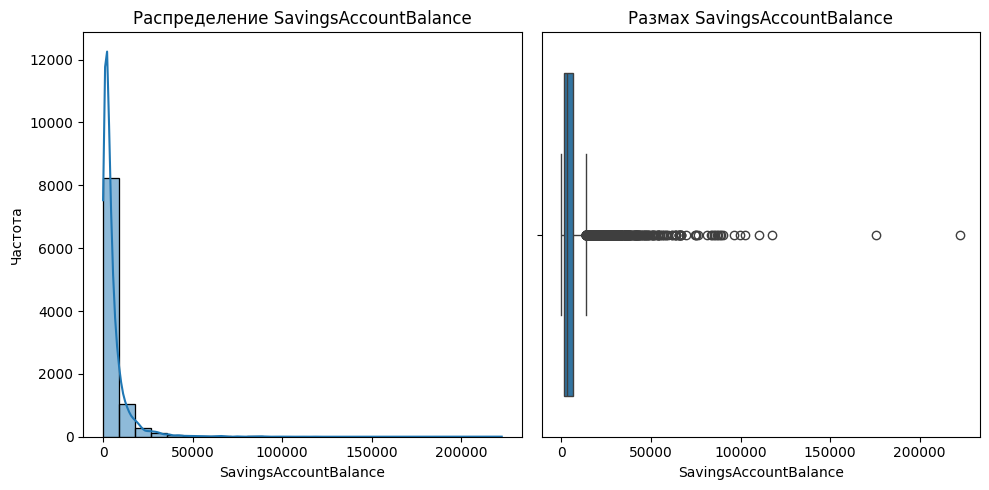

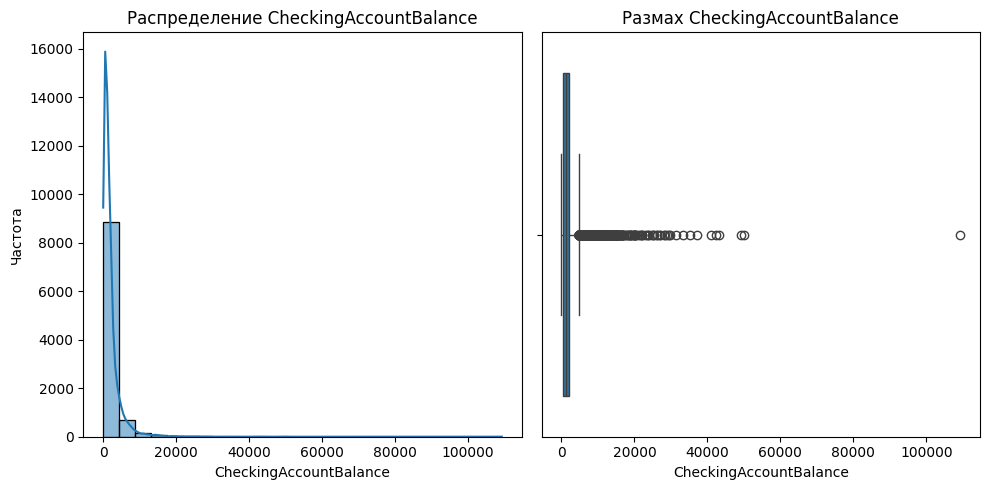

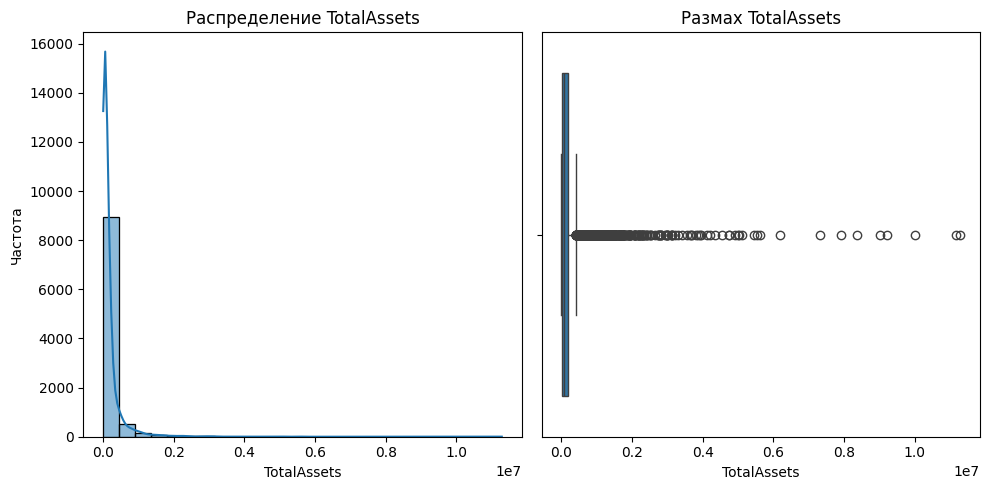

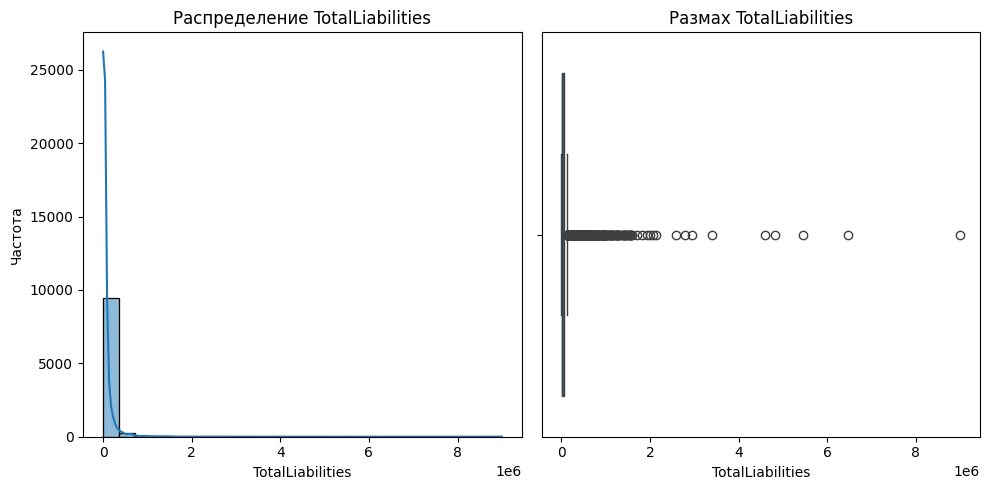

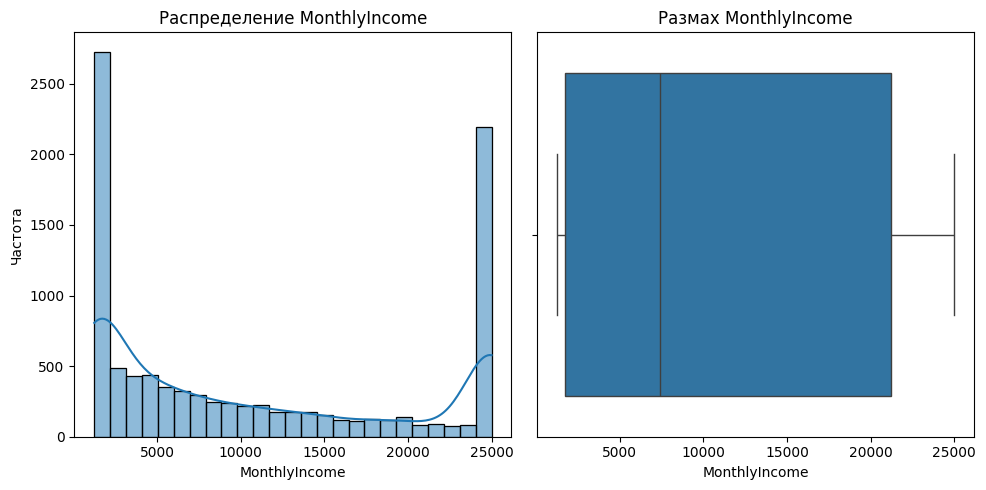

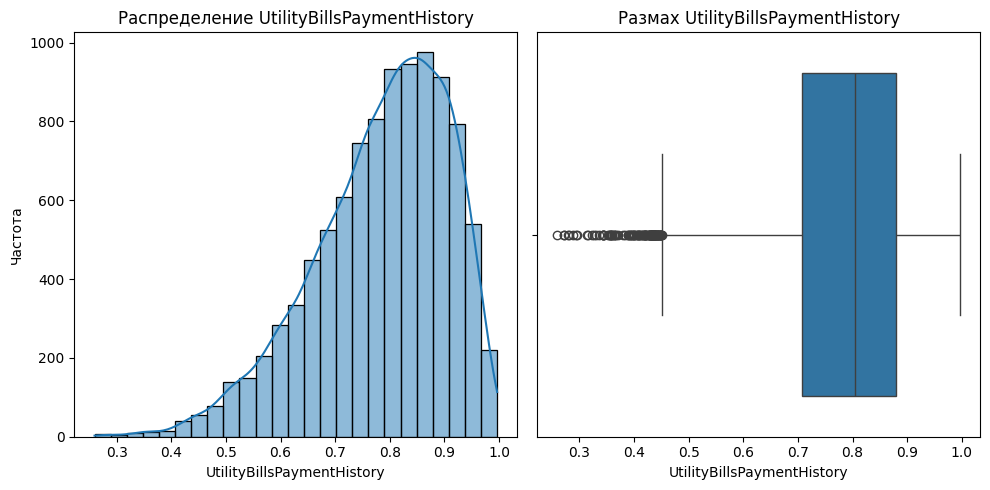

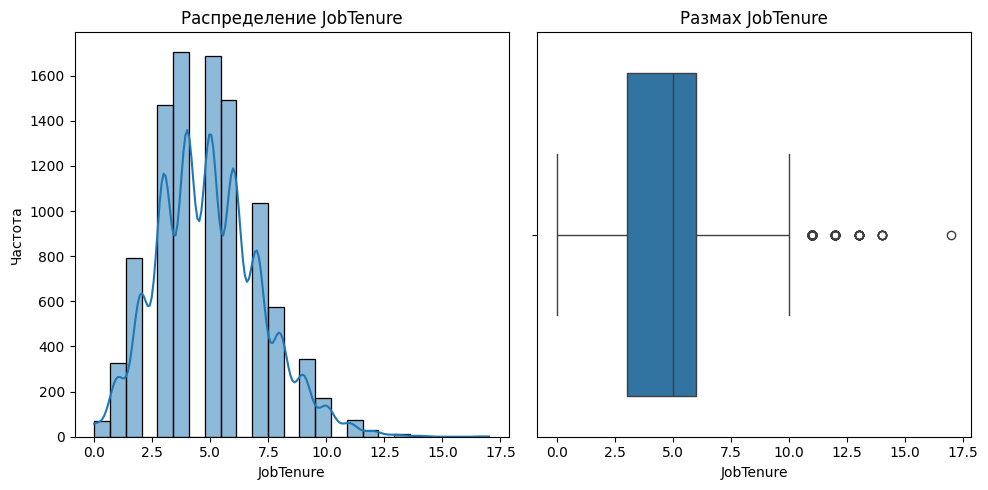

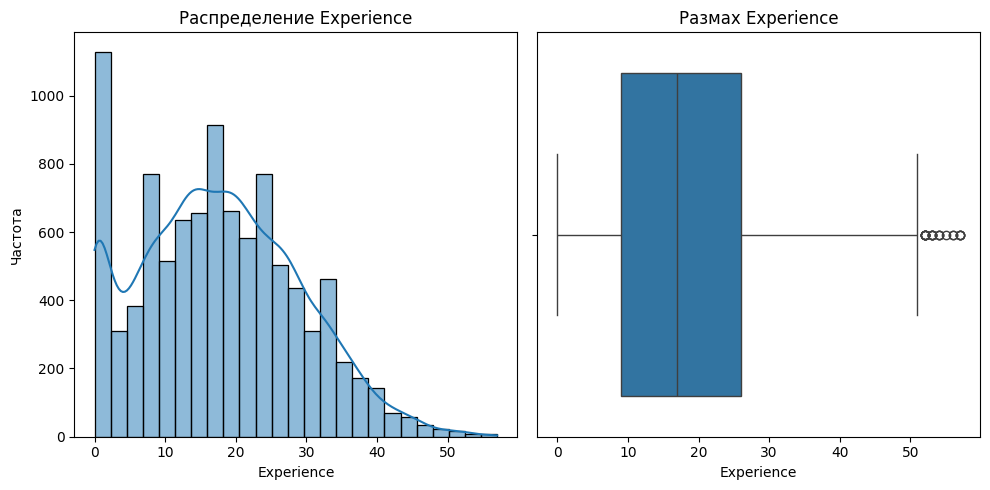

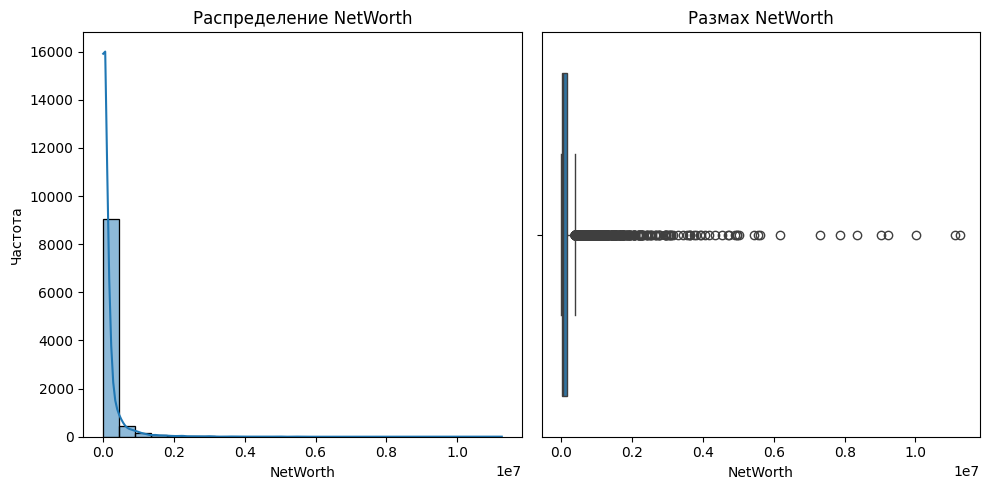

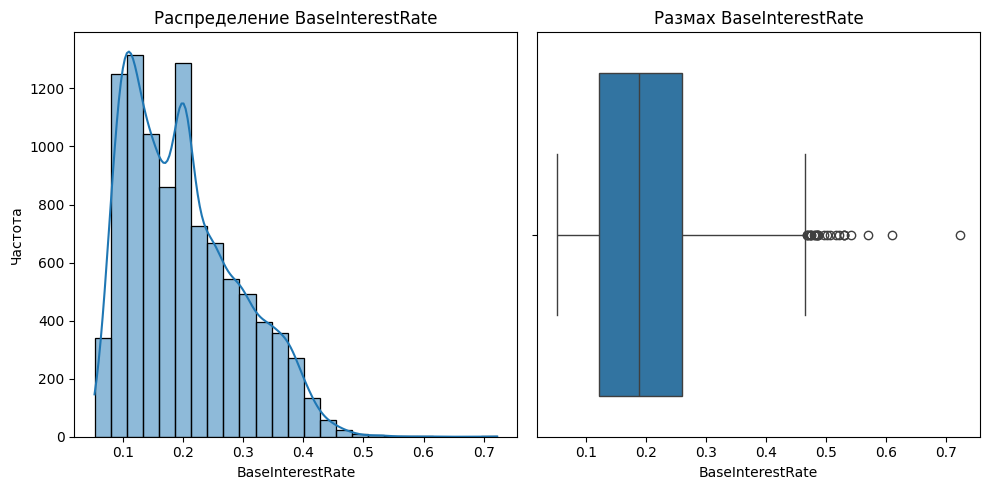

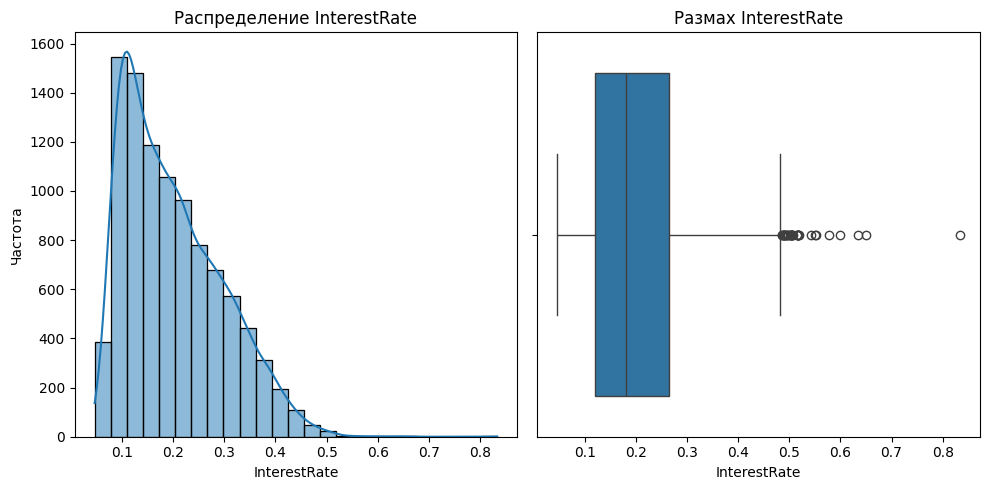

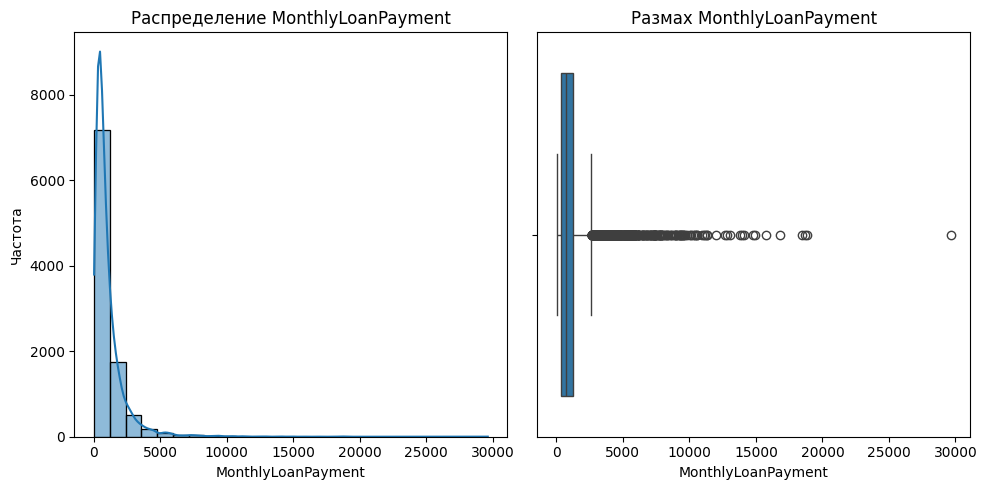

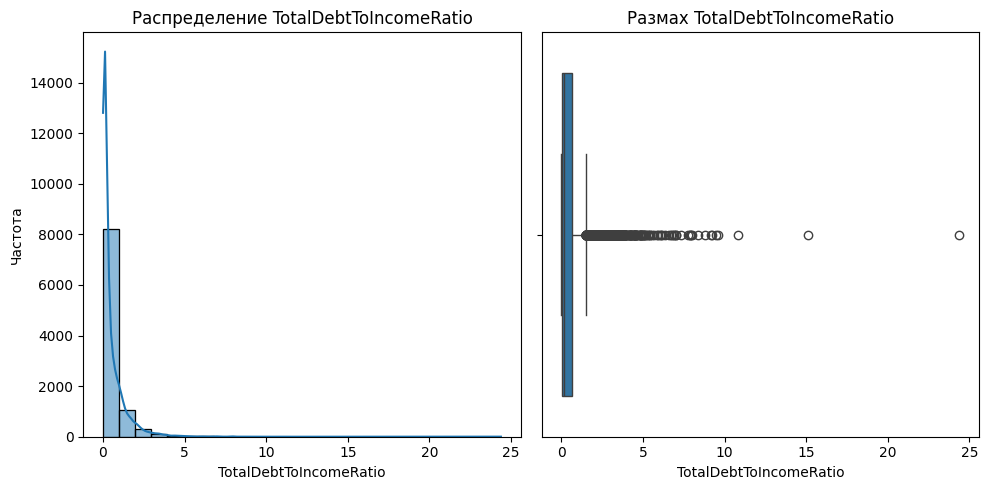

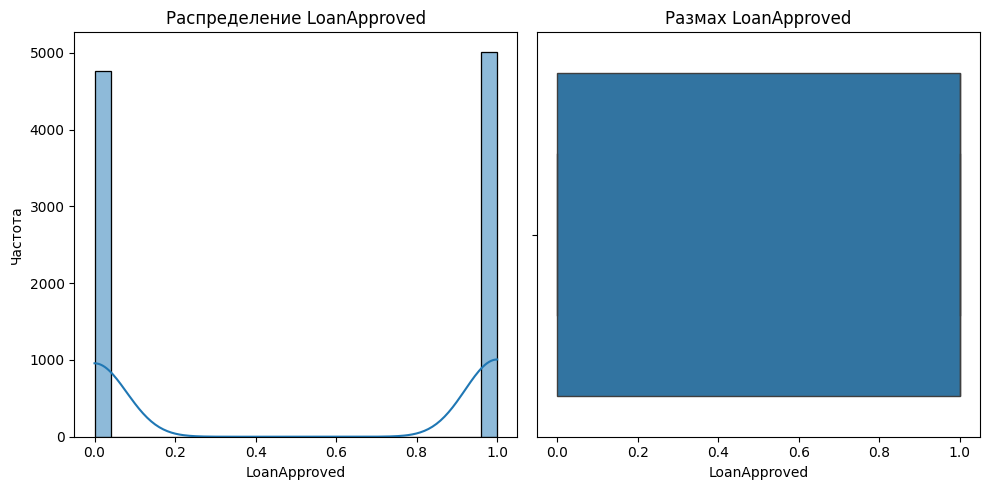

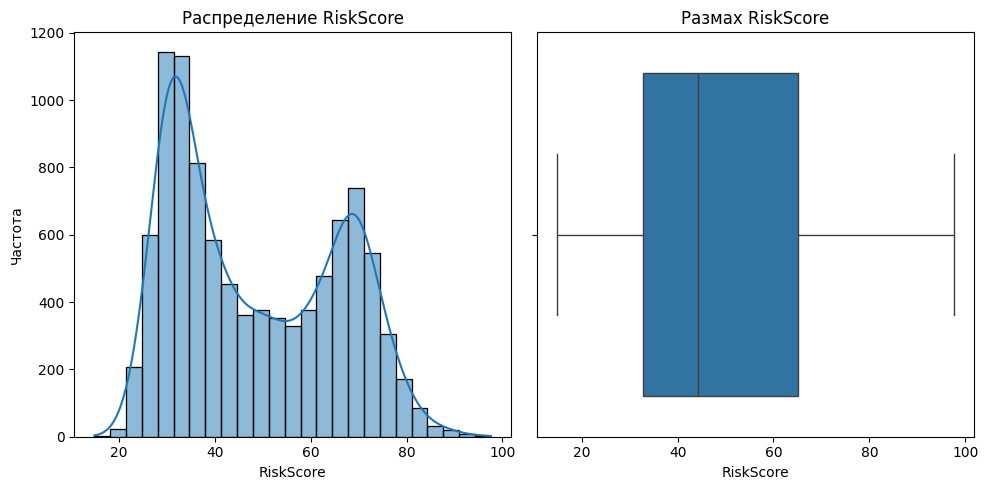

In [1007]:
numeric_features = [col for col in copy_train_df.select_dtypes(np.number).columns
                   if '_' not in col]
for feature in numeric_features:
    plot_distribution(train_df, feature)

# Выводы по преобразованиям

После применения Yeo-Johnson трансформации большинство признаков стали ближе к нормальному распределению - это особенно важно для линейной регрессии(она чувствительна к распределению данных). Это так же повлияло на структуру корреляций между признаками.
Обработка коррелирующих признаков: удаление из пары наиболее коррелующего признака; тот, у которого корреляция с RiskScore была наимьшей, дало положительный результат (Разбиение наиболее коррелирующих пар, у которых большие значения корреляции с RiskScore, ухудшают работу).

# Графики зависимостей признаков от целевой переменной (RiskScore)

In [1008]:
def visualize_features_vs_target(df: pd.DataFrame,
                               target_col: str = 'RiskScore',
                               figsize: tuple = (15, 30),
                               cols_per_row: int = 3):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_cols = numeric_cols.drop(target_col, errors='ignore')

    n_cols = min(cols_per_row, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        sns.regplot(
            data=df,
            x=col,
            y=target_col,
            ax=ax,
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'red'}
        )
        ax.set_title(f'{target_col} vs {col}')
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

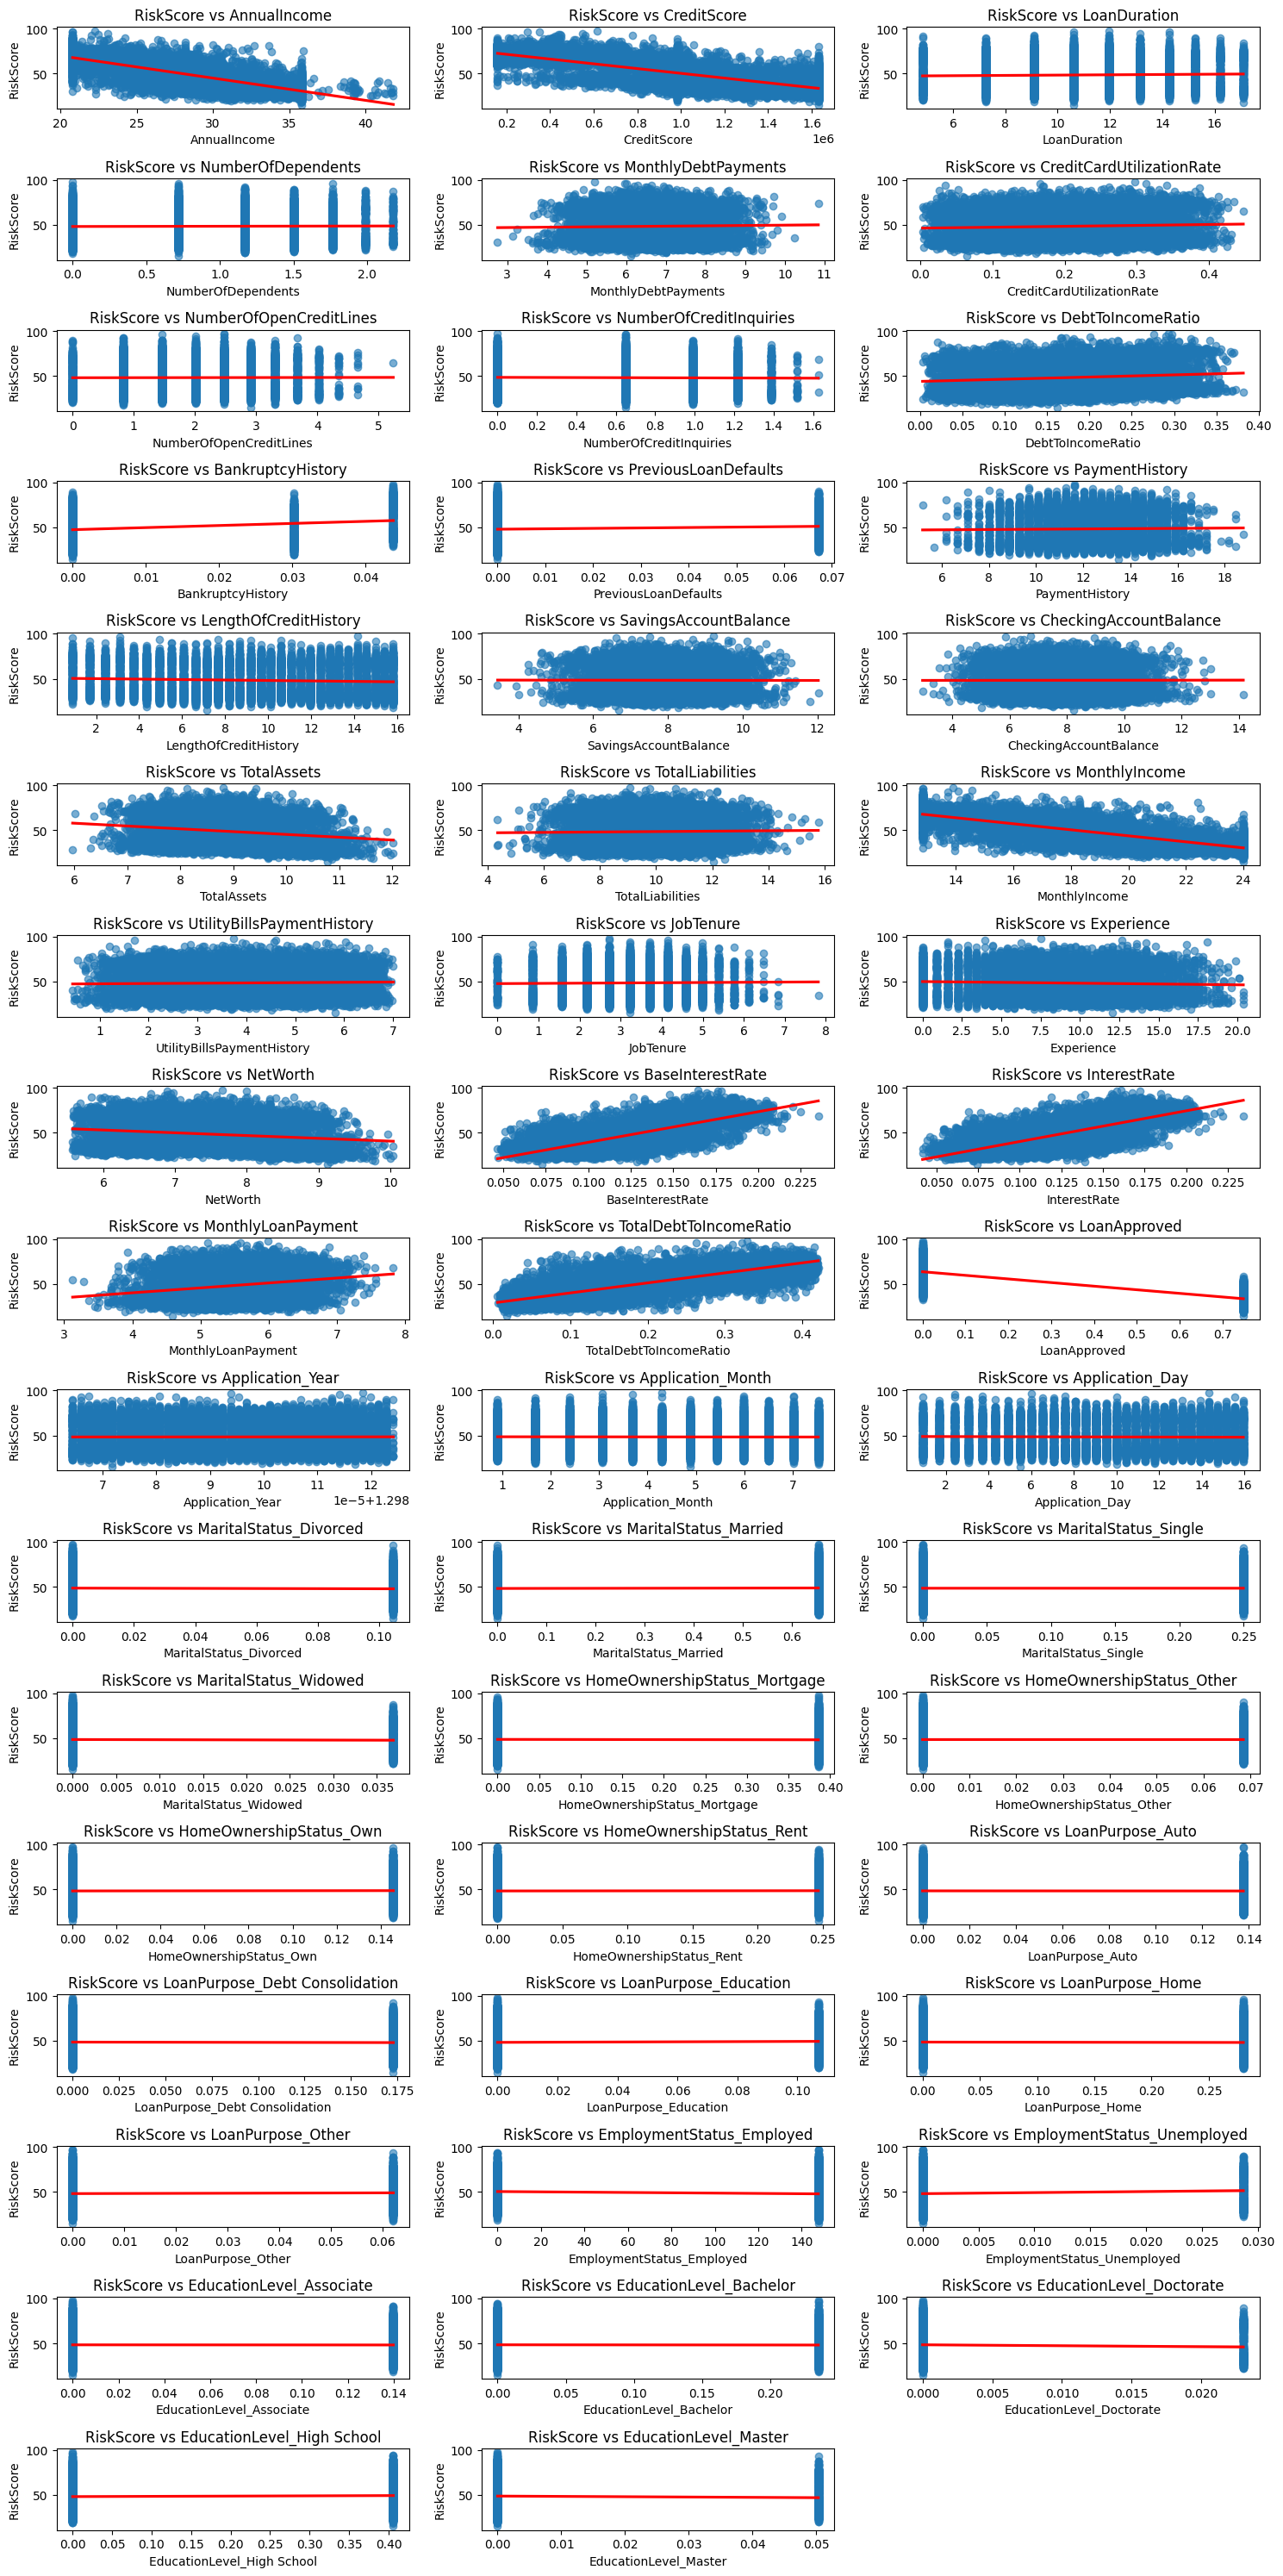

In [1009]:
visualize_features_vs_target(copy_train_df)

# Нормализация данных (z-score, min-max).

Z-score

In [1010]:
class ZScoreScaler:
  def __init__(self):
    self._mean = 0
    self._std = 1

  def fit(self, X: np.ndarray):
    self._mean = np.mean(X, axis=0)
    self._std = np.std(X, axis=0, ddof=0)

  def transform(self, X: np.ndarray):
    return (X - self._mean) / self._std

  def fit_transform(self, X: np.ndarray):
    self.fit(X)
    return self.transform(X)

MinMax

In [1011]:
class MinMaxScaler:
  def __init__(self):
    self._min = 0
    self._max = 1

  def fit(self, X: np.ndarray):
    self._min = np.min(X, axis=0)
    self._max = np.max(X, axis=0)

  def transform(self, X: np.ndarray):
    return (X - self._min) / (self._max - self._min)

  def fit_transform(self, X: np.ndarray):
    self.fit(X)
    return self.transform(X)

In [1012]:
df = pd.DataFrame({'Test1': [1, 2, 3, 4, 5], 'Test2': [1, 10, 100, 1000, 10000]})

In [1013]:
scaler = MinMaxScaler()
scaler.fit_transform(df.values)

array([[0.00000000e+00, 0.00000000e+00],
       [2.50000000e-01, 9.00090009e-04],
       [5.00000000e-01, 9.90099010e-03],
       [7.50000000e-01, 9.99099910e-02],
       [1.00000000e+00, 1.00000000e+00]])

In [1014]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit_transform(df.values)

array([[0.00000000e+00, 0.00000000e+00],
       [2.50000000e-01, 9.00090009e-04],
       [5.00000000e-01, 9.90099010e-03],
       [7.50000000e-01, 9.99099910e-02],
       [1.00000000e+00, 1.00000000e+00]])

In [1015]:
scaler = ZScoreScaler()
scaler.fit_transform(df.values)

array([[-1.41421356, -0.56853297],
       [-0.70710678, -0.56622936],
       [ 0.        , -0.54319317],
       [ 0.70710678, -0.31283135],
       [ 1.41421356,  1.99078685]])

In [1016]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit_transform(df.values)

array([[-1.41421356, -0.56853297],
       [-0.70710678, -0.56622936],
       [ 0.        , -0.54319317],
       [ 0.70710678, -0.31283135],
       [ 1.41421356,  1.99078685]])

# Метрики

In [1017]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [1018]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [1019]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [1020]:
def r2(y_true, y_pred):
    res = np.sum((y_true - y_pred) ** 2)
    tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (res / tot)

In [1021]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [1022]:
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

print("✔ Mean Squared Error:")
print("  sklearn:", mean_squared_error(y_true, y_pred))
print("  custom :", mse(y_true, y_pred))

print("✔ Mean Absolute Error:")
print("  sklearn:", mean_absolute_error(y_true, y_pred))
print("  custom :", mae(y_true, y_pred))

print("✔ Mean Absolute Percentage Error:")
print("  sklearn:", mean_absolute_percentage_error(y_true, y_pred))
print("  custom :", mape(y_true, y_pred))

print("✔ R² Score:")
print("  sklearn:", r2_score(y_true, y_pred))
print("  custom :", r2(y_true, y_pred))

✔ Mean Squared Error:
  sklearn: 0.375
  custom : 0.375
✔ Mean Absolute Error:
  sklearn: 0.5
  custom : 0.5
✔ Mean Absolute Percentage Error:
  sklearn: 0.3273809523809524
  custom : 0.3273809523809524
✔ R² Score:
  sklearn: 0.9486081370449679
  custom : 0.9486081370449679


# Линейная регрессия

In [1023]:
from typing import Literal
class LinearRegression:
    def __init__(self,
                 learn_coef=0.01,
                 learn_pow=0.25,
                 max_iter=1000,
                 regularization: Literal['l1', 'l2', 'elasticNet', None] = None,
                 reg_coef=0.0001,
                 net_l1_ratio=0.15,
                 random_state=None):

        self.learn_coef = learn_coef
        self.learn_pow = learn_pow
        self.max_iter = max_iter
        self.regularization = regularization
        self.reg_coef = reg_coef
        self.net_l1_ratio = net_l1_ratio
        self.random_state = random_state
        self._is_custom_linear_regression = True

        self.weights = None

        if random_state is not None:
            np.random.seed(random_state)

    def _add_intercept(self, X):
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _get_learning_rate(self, k):
        return self.learn_coef / max(1, k) ** self.learn_pow

    def _init_weights(self, n_features):
      self.weights = np.random.uniform(-1, 1, size=(n_features, 1))

    def _update_weights(self, grad, eta, i, X, y, verbose):
      reg_grad = np.zeros_like(grad)
      reg_grad[1:] = self._get_reg_gradient(self.weights[1:])
      self.weights -= eta * (grad + reg_grad)

      if verbose and i % 100 == 0:
          loss = np.mean((X @ self.weights - y)**2) + self._regularize(self.weights)
          # print(f"Iter {i}, Loss: {loss:.4f}") debug

    def _get_gradient(self, w, X, y, mode='gd', batch_size=None):
        if mode == 'gd':
            pred = X @ w
            return 2 / len(X) * X.T @ (pred - y)
        elif mode == 'sgd':
            idx = np.random.randint(len(X))
            xi = X[idx:idx+1]
            yi = y[idx:idx+1]
            return 2 * xi.T * (xi @ w - yi)
        else:
            raise ValueError(f"Неправильный режим: {mode}")

    def _get_reg_gradient(self, w):
        if not self.regularization:
            return 0
        if self.regularization == 'l1':
            return self.reg_coef * np.sign(w)
        if self.regularization == 'l2':
            return self.reg_coef * w
        if self.regularization == 'elasticNet':
            return self.reg_coef * (
                self.net_l1_ratio * np.sign(w) +
                (1 - self.net_l1_ratio) * w
            )
        raise ValueError(f"Неправильно задана регулиризация: {self.regularization}")

    def _compute_gradient(self, w, X, y, mode='gd', batch_size=None):
      if mode == 'gd':
          pred = X @ w
          return 2 / len(X) * X.T @ (pred - y)
      elif mode == 'sgd':
          idx = np.random.randint(len(X))
          xi = X[idx:idx+1]
          yi = y[idx:idx+1]
          return 2 * xi.T @ (xi @ w - yi)

    def _analytic_fit(self, X, y):
      self.weights = np.linalg.pinv(X) @ y

    def _gradient_descent(self, X, y, verbose=False):
        self._init_weights(X.shape[1])
        for i in range(1, self.max_iter + 1):
            eta = self._get_learning_rate(i)
            grad = self._compute_gradient(self.weights, X, y, mode='gd')
            self._update_weights(grad, eta, i, X, y, verbose)

    def _stochastic_gradient_descent(self, X, y, batch_size, verbose=False):
        self._init_weights(X.shape[1])
        for i in range(1, self.max_iter + 1):
            eta = self._get_learning_rate(i)
            grad = self._compute_gradient(self.weights, X, y, mode='sgd', batch_size=batch_size)
            self._update_weights(grad, eta, i, X, y, verbose)

    def fit(self, X, y, mode='analytic', batch_size=32, verbose=False):
      X = self._add_intercept(X)
      y = y.reshape(-1, 1)

      if mode == 'analytic':
          self._analytic_fit(X, y)
      elif mode == 'gd':
          self._gradient_descent(X, y, verbose)
      elif mode in ['sgd', 'mini-batch']:
          self._stochastic_gradient_descent(X, y, batch_size, verbose)
      else:
          raise ValueError(f"Неправильный режим: {mode}")

    def _regularize(self, weights):
        if not self.regularization:
            return 0
        w = weights[1:]
        if self.regularization == 'l2':
            return self.reg_coef * np.sum(w**2)
        if self.regularization == 'l1':
            return self.reg_coef * np.sum(np.abs(w))
        if self.regularization == 'elasticNet':
            return self.reg_coef * (
                self.net_l1_ratio * np.sum(np.abs(w)) +
                (1 - self.net_l1_ratio) * np.sum(w**2)
            )

    def predict(self, X):
        if self.weights is None:
            raise RuntimeError("Модель должна быть задана перед прогнозированием")
        X = self._add_intercept(X)
        return (X @ self.weights).reshape(-1)

# Кросс-валидация

In [1024]:
def kfold_split(X, y, k=5, shuffle=True, random_state=None):
    n_samples = len(X)
    indices = np.arange(n_samples)

    if shuffle:
        rng = np.random.default_rng(seed=random_state)
        rng.shuffle(indices)

    fold_sizes = np.full(k, n_samples // k)
    fold_sizes[:n_samples % k] += 1

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate([indices[:start], indices[stop:]])
        folds.append((train_idx, test_idx))
        current = stop
    return folds

def leave_one_out_split(X, y):
    n_samples = len(X)
    return [(np.delete(np.arange(n_samples), i), np.array([i])) for i in range(n_samples)]


# Тестирование регрессии

In [1025]:
def cross_val_score(model, X, y, split_fn, mode='analytic', metric_fns=None, **fit_kwargs):
    if metric_fns is None:
        metric_fns = [mean_squared_error, r2_score]
    if callable(metric_fns):
        metric_fns = [metric_fns]
    scores = [[] for _ in metric_fns]
    splits = split_fn(X, y)

    for train_idx, test_idx in splits:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        if hasattr(model, '_is_custom_linear_regression'):
            model.fit(X_train, y_train, mode)
        else:
            model.fit(X_train, y_train)
        preds = model.predict(X_test)
        for i, metric_fn in enumerate(metric_fns):
            scores[i].append(metric_fn(y_test, preds))

    return np.mean(scores)

In [1026]:
import sklearn
x = copy_train_df.drop(columns='RiskScore').values
y = copy_train_df['RiskScore'].values
scaler = sklearn.preprocessing.StandardScaler()
x = scaler.fit_transform(x)

In [1027]:
def compare_models(models, titles, X, y, cv=None, mode='analytic'):
    from time import time
    results = []

    for model, title in zip(models, titles):
        start = time()
        mse = cross_val_score(model, X, y, cv, mode, mean_squared_error)
        r2 = cross_val_score(model, X, y, cv, mode, r2_score)
        elapsed = (time() - start) * 1000
        results.append((mse, r2, elapsed))

    return pd.DataFrame(results, columns=["CV MSE", "CV R2", "Time, ms"], index=titles)


In [1028]:
my_model = LinearRegression()
sk_model = sklearn.linear_model.LinearRegression()

cv = lambda X, y: kfold_split(X, y, k=5, shuffle=True, random_state=42)
mode='analytic'

compare_models(
    [my_model, sk_model],
    ['My LinearRegression', 'SK LinearRegression'],
    x, y, cv, mode
)

CV MSE     CV R2    Time, ms
My LinearRegression  17.337934  0.941586  415.116787
SK LinearRegression  17.337934  0.941586  403.172255

In [1029]:
my_gd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=43)
my_sgd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.15, max_iter=1000, random_state=43)
sk_predictor = sklearn.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=1000, random_state=43, penalty=None)

mode='sgd'

compare_models(
    [my_sgd_predictor, sk_model],
    ['My SGDLinearRegression', 'SK SGDLinearRegression'],
    x, y, cv, mode
)

CV MSE     CV R2    Time, ms
My SGDLinearRegression  22.134021  0.927114  271.436930
SK SGDLinearRegression  17.337934  0.941586  278.102398

In [1030]:
mode='gd'
compare_models(
    [my_gd_predictor],
    ['My GDLinearRegression'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My GDLinearRegression  19.482054  0.933836  8714.335918

In [1031]:
my_gd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=43, regularization='l1', reg_coef=1e-6)
my_sgd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.15, max_iter=10000, random_state=43, regularization='l1', reg_coef=1e-6)
sk_predictor = sklearn.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=43, penalty='l1', alpha=1e-6)

mode='sgd'

compare_models(
    [my_sgd_predictor, sk_model],
    ['My SGDLinearRegressionL1', 'SK SGDLinearRegressionL1'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My SGDLinearRegressionL1  20.065803  0.931627  2101.551056
SK SGDLinearRegressionL1  17.337934  0.941586   264.790058

In [1032]:
mode='gd'

compare_models(
    [my_gd_predictor],
    ['My GDLinearRegressionL1'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My GDLinearRegressionL1  19.634278  0.934037  8764.488935

In [1033]:
my_gd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=43, regularization='l2', reg_coef=1e-6)
my_sgd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.15, max_iter=10000, random_state=43, regularization='l2', reg_coef=1e-6)
sk_predictor = sklearn.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=43, penalty='l2', alpha=1e-6)

mode='sgd'

compare_models(
    [my_sgd_predictor, sk_model],
    ['My SGDLinearRegressionL2', 'SK SGDLinearRegressionL2'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My SGDLinearRegressionL2  20.065810  0.931627  2051.917315
SK SGDLinearRegressionL2  17.337934  0.941586   258.400679

In [1034]:
mode='gd'

compare_models(
    [my_gd_predictor],
    ['My GDLinearRegressionL2'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My GDLinearRegressionL2  19.634282  0.934037  7975.647211

In [1035]:
my_gd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, net_l1_ratio=0.05, random_state=43, regularization='elasticNet', reg_coef=1e-6)
my_sgd_predictor = LinearRegression(learn_coef=0.01, learn_pow=0.15, max_iter=10000, net_l1_ratio=0.05, random_state=43, regularization='elasticNet', reg_coef=1e-6)
sk_predictor = sklearn.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=43, penalty='elasticnet', alpha=1e-6)

mode='sgd'

compare_models(
    [my_sgd_predictor, sk_model],
    ['My SGDLinearRegressionL2', 'SK SGDLinearRegressionL2'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My SGDLinearRegressionL2  20.065809  0.931627  3487.754345
SK SGDLinearRegressionL2  17.337934  0.941586   267.647505

In [1036]:
mode='gd'

compare_models(
    [my_gd_predictor],
    ['My GDLinearRegressionL2'],
    x, y, cv, mode
)

CV MSE     CV R2     Time, ms
My GDLinearRegressionL2  19.634282  0.934037  7888.387918

# Результат

In [978]:
predictor = LinearRegression()

x = copy_train_df.drop(columns='RiskScore').values
y = copy_train_df['RiskScore'].values
t = copy_test_df.drop(columns='ID').values

scaler = ZScoreScaler()
x = scaler.fit_transform(x)
t = scaler.transform(t)


predictor.fit(x, y)
pred = predictor.predict(t)

df = pd.DataFrame({'ID': np.arange(0, len(pred)), 'RiskScore': pred.reshape(-1)})
df.to_csv('res.csv', index=False)